In [98]:
from preprocessing_last20 import *
from encoder import Encoder
from decoder import Decoder
from classifier import FaceRecognizer
import torch.optim as optim
from torch import nn

# device = torch.device('cuda:3')
device = torch.device('cpu')
encoder = Encoder().to(device) # input 64*64 image, output 128 feacture vector
decoder = Decoder().to(device) # input 128 feature vector, output 64*64 image
classifier = FaceRecognizer().to(device)
attack_targets = torch.tensor([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]).to(device)

In [99]:
encoder.load_state_dict(torch.load('train_VAE_last20encoder.pt'))
decoder.load_state_dict(torch.load('train_VAE_last20decoder.pt'))
classifier.load_state_dict(torch.load('classifier.pt'))

<All keys matched successfully>

In [100]:
torch.softmax(classifier(decoder(encoder(test_data[84]))),-1)

tensor([[2.6236e-05, 8.9009e-05, 1.4363e-03, 1.0521e-04, 1.7643e-03, 1.2994e-06,
         4.3276e-04, 2.6213e-06, 4.6721e-02, 9.2376e-04, 8.5350e-04, 4.2007e-02,
         2.8767e-02, 9.9955e-03, 8.7157e-03, 3.3037e-05, 1.4396e-02, 2.6906e-04,
         1.1645e-04, 9.8883e-05, 2.2034e-01, 3.3121e-03, 3.0328e-02, 3.4214e-03,
         8.7782e-02, 8.5858e-04, 1.9673e-03, 1.8089e-02, 3.5339e-03, 1.6239e-03,
         3.7305e-01, 8.8538e-05, 6.7373e-04, 3.3042e-03, 1.6850e-02, 1.4058e-04,
         1.3288e-02, 1.8649e-03, 4.1122e-02, 2.1600e-02]],
       grad_fn=<SoftmaxBackward>)

In [101]:
torch.softmax(classifier(test_data[84]),-1)

tensor([[1.4803e-10, 6.3975e-11, 7.8095e-08, 4.2615e-09, 2.5216e-05, 3.7814e-09,
         4.2211e-07, 7.1756e-11, 9.9961e-01, 2.9805e-05, 3.3020e-08, 9.0766e-05,
         1.1567e-05, 1.8725e-09, 3.3143e-06, 1.7427e-06, 3.6545e-06, 5.1248e-05,
         6.4311e-09, 1.8950e-07, 3.6552e-06, 1.1109e-07, 3.6957e-05, 3.1782e-06,
         1.6277e-05, 1.1007e-10, 6.0287e-08, 3.9291e-07, 1.3096e-06, 4.8502e-05,
         4.0846e-05, 4.5509e-10, 2.0381e-06, 2.9761e-09, 1.0901e-05, 4.1997e-08,
         2.5911e-09, 2.9169e-07, 1.6580e-06, 3.9705e-06]],
       grad_fn=<SoftmaxBackward>)

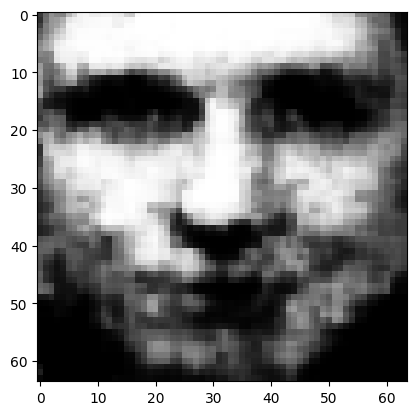

In [102]:
tensor_to_picture(decoder(encoder(test_data[84])).detach().cpu().numpy()[0][0])

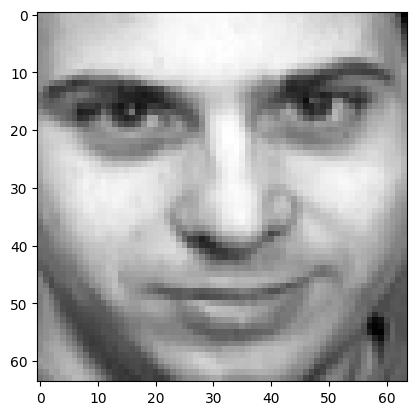

In [103]:
tensor_to_picture(test_data[84].detach().cpu().numpy()[0][0])

In [174]:
def optimize_z(decoder, classifier, optimizer_z, criterion, target, z):
    decoder.eval()
    classifier.eval()
    optimizer_z.zero_grad()
    result = classifier(decoder(z))
    loss = criterion(result,attack_targets[target])
    loss.backward()
    optimizer_z.step()
    return loss.item()
    

In [175]:
def optimize_z_eps(z, eps, lr, reg, lr_decay, target=8):
    for epoch in range(eps): 
        optimizer_z = optim.SGD([z], lr=lr*lr_decay**epoch, momentum=0.9, weight_decay=reg, nesterov=False)
        criterion = nn.CrossEntropyLoss(reduction = 'sum')
        epoch_loss = optimize_z(decoder, classifier, optimizer_z, criterion, target, z)
        print("loss(generator): ", epoch_loss)
        if epoch%200 == 0:
            tensor_to_picture(decoder(z).detach().cpu().numpy()[0][0])

In [210]:
z = 0
for i in range(train_data.shape[0]):
    z += encoder(train_data[i]).detach()
z = z/train_data.shape[0]
z.requires_grad_(True)

tensor([[-1.1372, -0.0132,  0.7626,  1.6067,  1.1768,  1.1282, -0.8425,  0.3515,
          0.0316, -0.9363, -0.2092,  0.3770, -1.2080,  0.5347,  0.0050,  0.2629,
          1.3908,  0.1467,  1.1047, -0.4159, -0.6600,  1.3143, -0.4640,  0.7287,
         -0.2395,  1.6009, -0.0878,  0.2533, -0.1370,  1.1030, -0.5067,  0.8531,
         -0.6415, -0.5761, -1.0260,  0.2794, -0.5269,  0.5922, -0.8701,  1.1570,
          0.0633,  0.9107,  0.6680,  0.2228,  0.4140,  0.2073,  0.8432,  0.2497,
          0.4529, -1.2700,  0.2615,  0.3259, -0.3689, -0.1456,  0.4655, -0.3998,
         -0.3024, -0.7591,  0.1766,  0.5147, -0.2417, -0.4310, -0.3551, -0.8770]],
       requires_grad=True)

loss(generator):  13.345393180847168


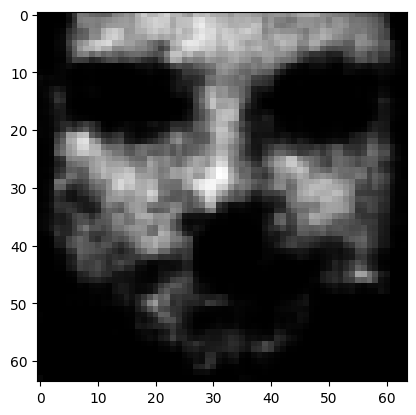

loss(generator):  10.047881126403809
loss(generator):  6.741922378540039
loss(generator):  4.729196548461914
loss(generator):  3.3817152976989746
loss(generator):  2.8305206298828125
loss(generator):  2.488016366958618
loss(generator):  2.1604347229003906
loss(generator):  1.815592885017395
loss(generator):  1.518043875694275
loss(generator):  1.299286127090454
loss(generator):  1.1458649635314941
loss(generator):  1.023963451385498
loss(generator):  0.9210245013237
loss(generator):  0.8388826847076416
loss(generator):  0.7779477834701538
loss(generator):  0.722204327583313
loss(generator):  0.6692404747009277
loss(generator):  0.6243136525154114
loss(generator):  0.582307755947113
loss(generator):  0.5449499487876892
loss(generator):  0.5129928588867188
loss(generator):  0.48540452122688293
loss(generator):  0.46096763014793396
loss(generator):  0.43895775079727173
loss(generator):  0.42057695984840393
loss(generator):  0.40578651428222656
loss(generator):  0.39321625232696533
loss(ge

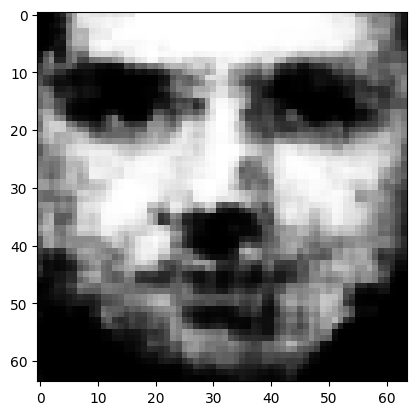

loss(generator):  0.19213172793388367
loss(generator):  0.19205588102340698
loss(generator):  0.1919763833284378
loss(generator):  0.1918996423482895
loss(generator):  0.1918252557516098
loss(generator):  0.19175027310848236
loss(generator):  0.19167901575565338
loss(generator):  0.1916067749261856
loss(generator):  0.19154348969459534
loss(generator):  0.19147035479545593
loss(generator):  0.19140677154064178
loss(generator):  0.19133834540843964
loss(generator):  0.1912696212530136
loss(generator):  0.19120730459690094
loss(generator):  0.19113552570343018
loss(generator):  0.19107259809970856
loss(generator):  0.19100552797317505
loss(generator):  0.19094151258468628
loss(generator):  0.1908784806728363
loss(generator):  0.19081583619117737
loss(generator):  0.1907566338777542
loss(generator):  0.19069309532642365
loss(generator):  0.19063299894332886
loss(generator):  0.19057123363018036
loss(generator):  0.19051161408424377
loss(generator):  0.19045239686965942
loss(generator):  0

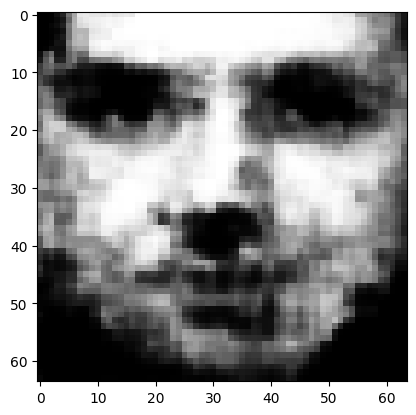

loss(generator):  0.18622611463069916
loss(generator):  0.18621978163719177
loss(generator):  0.1862126588821411
loss(generator):  0.18620562553405762
loss(generator):  0.18619929254055023
loss(generator):  0.1861920803785324
loss(generator):  0.18618574738502502
loss(generator):  0.18617941439151764
loss(generator):  0.1861724853515625
loss(generator):  0.18616624176502228
loss(generator):  0.18615981936454773
loss(generator):  0.1861530840396881
loss(generator):  0.18614764511585236
loss(generator):  0.1861412078142166
loss(generator):  0.18613487482070923
loss(generator):  0.18612903356552124
loss(generator):  0.18612289428710938
loss(generator):  0.18611736595630646
loss(generator):  0.1861114203929901
loss(generator):  0.18610548973083496
loss(generator):  0.1860998421907425
loss(generator):  0.1860944926738739
loss(generator):  0.1860884577035904
loss(generator):  0.186083123087883
loss(generator):  0.1860777735710144
loss(generator):  0.18607193231582642
loss(generator):  0.1860

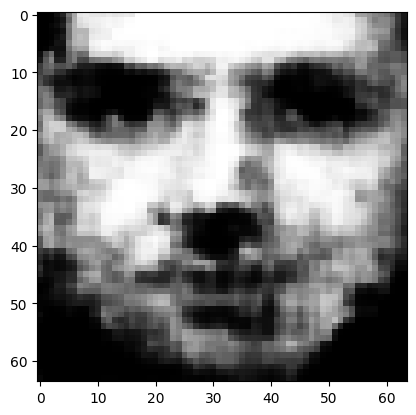

loss(generator):  0.18562914431095123
loss(generator):  0.1856282502412796
loss(generator):  0.1856272667646408
loss(generator):  0.18562647700309753
loss(generator):  0.18562577664852142
loss(generator):  0.18562458455562592
loss(generator):  0.18562400341033936
loss(generator):  0.18562300503253937
loss(generator):  0.1856222152709961
loss(generator):  0.18562161922454834
loss(generator):  0.1856205314397812
loss(generator):  0.18561963737010956
loss(generator):  0.18561884760856628
loss(generator):  0.185618057847023
loss(generator):  0.1856175661087036
loss(generator):  0.18561656773090363
loss(generator):  0.1856158822774887
loss(generator):  0.18561509251594543
loss(generator):  0.18561428785324097
loss(generator):  0.18561340868473053
loss(generator):  0.18561241030693054
loss(generator):  0.18561172485351562
loss(generator):  0.18561102449893951
loss(generator):  0.1856103390455246
loss(generator):  0.18560974299907684
loss(generator):  0.18560895323753357
loss(generator):  0.1

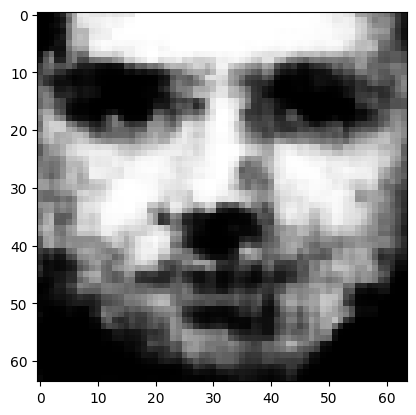

loss(generator):  0.18555131554603577
loss(generator):  0.1855510175228119
loss(generator):  0.18555092811584473
loss(generator):  0.18555082380771637
loss(generator):  0.185550719499588
loss(generator):  0.18555063009262085
loss(generator):  0.1855505257844925
loss(generator):  0.18555042147636414
loss(generator):  0.18555012345314026
loss(generator):  0.18555012345314026
loss(generator):  0.18555012345314026
loss(generator):  0.18554992973804474
loss(generator):  0.18554973602294922
loss(generator):  0.18554973602294922
loss(generator):  0.18554963171482086
loss(generator):  0.1855495423078537
loss(generator):  0.18554943799972534
loss(generator):  0.18554933369159698
loss(generator):  0.18554924428462982
loss(generator):  0.1855490356683731
loss(generator):  0.1855488419532776
loss(generator):  0.1855488419532776
loss(generator):  0.1855488419532776
loss(generator):  0.18554894626140594
loss(generator):  0.18554873764514923
loss(generator):  0.18554873764514923
loss(generator):  0.1

In [211]:
optimize_z_eps(z, 1000, 1, 0.001, 0.99, target=8)

In [212]:
torch.softmax(classifier(decoder(z)),-1)

tensor([[7.9223e-07, 1.5363e-05, 6.5162e-03, 4.5193e-04, 4.8231e-04, 1.2451e-05,
         2.4245e-03, 1.5816e-06, 8.3065e-01, 3.0184e-03, 6.7437e-03, 1.4768e-03,
         6.1190e-04, 5.4882e-04, 1.9018e-03, 2.5134e-04, 6.5924e-03, 3.7779e-04,
         3.1057e-04, 4.3617e-04, 5.2234e-03, 2.7055e-03, 4.0560e-02, 1.6105e-04,
         1.0059e-02, 4.4439e-05, 9.4630e-04, 1.1407e-02, 6.4522e-03, 2.9570e-03,
         6.0889e-03, 3.0687e-05, 1.1627e-03, 3.6510e-04, 2.8285e-03, 1.1790e-04,
         5.9685e-04, 1.4359e-02, 1.4733e-03, 2.9631e-02]],
       grad_fn=<SoftmaxBackward>)

In [172]:
z

tensor([[-3.4728, -0.9701,  0.1686,  5.0644,  2.5345,  2.9445, -4.1595,  0.0770,
         -1.1343, -5.1119,  1.9212,  1.9337, -1.8920,  2.1465, -1.2683, -0.5592,
          2.4686,  2.4428,  3.5828, -0.6449, -0.0410,  3.5073,  0.2752,  1.2795,
         -0.5342,  4.3017, -2.5456, -1.0042, -0.4003,  5.5978, -0.2058,  2.8611,
         -3.6347, -1.1085, -2.7682,  0.8586,  0.9917,  1.6685, -1.7761,  4.1645,
         -0.0924,  1.3615,  2.6513,  1.8563, -0.3572, -0.2012,  2.4999,  0.1646,
          2.1435, -3.3638,  1.2908,  2.3567,  2.9997, -1.6411, -0.6171, -3.6401,
          0.9737, -3.0526, -1.0966,  2.9042,  0.7588,  0.2249, -1.7021, -2.7414]],
       requires_grad=True)

loss(generator):  15.824920654296875


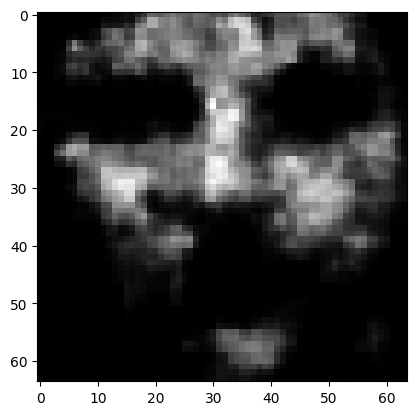

loss(generator):  12.962010383605957
loss(generator):  10.187162399291992
loss(generator):  7.81658935546875
loss(generator):  6.062570095062256
loss(generator):  4.301966667175293
loss(generator):  3.3145527839660645
loss(generator):  2.519465208053589
loss(generator):  1.9658910036087036
loss(generator):  1.5723448991775513
loss(generator):  1.3458366394042969
loss(generator):  1.1784534454345703
loss(generator):  1.0510332584381104
loss(generator):  0.9486892223358154
loss(generator):  0.8821927905082703
loss(generator):  0.7986187934875488
loss(generator):  0.7394673228263855
loss(generator):  0.689339816570282
loss(generator):  0.6478062868118286
loss(generator):  0.6106337308883667
loss(generator):  0.5784353017807007
loss(generator):  0.5507656335830688
loss(generator):  0.5254760384559631
loss(generator):  0.49974340200424194
loss(generator):  0.4759199619293213
loss(generator):  0.45593804121017456
loss(generator):  0.44292935729026794
loss(generator):  0.4272051453590393
loss

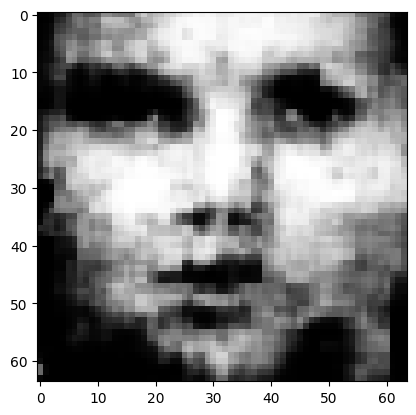

loss(generator):  0.15589526295661926
loss(generator):  0.1558058112859726
loss(generator):  0.15571379661560059
loss(generator):  0.15562452375888824
loss(generator):  0.15553565323352814
loss(generator):  0.15544942021369934
loss(generator):  0.15536512434482574
loss(generator):  0.15527939796447754
loss(generator):  0.15519508719444275
loss(generator):  0.1551118940114975
loss(generator):  0.15503308176994324
loss(generator):  0.1549525409936905
loss(generator):  0.15487238764762878
loss(generator):  0.15479294955730438
loss(generator):  0.1547156423330307
loss(generator):  0.15463945269584656
loss(generator):  0.15456286072731018
loss(generator):  0.1544899195432663
loss(generator):  0.15441811084747314
loss(generator):  0.1543470174074173
loss(generator):  0.15427836775779724
loss(generator):  0.15420734882354736
loss(generator):  0.15413153171539307
loss(generator):  0.1540566384792328
loss(generator):  0.15398265421390533
loss(generator):  0.15390998125076294
loss(generator):  0

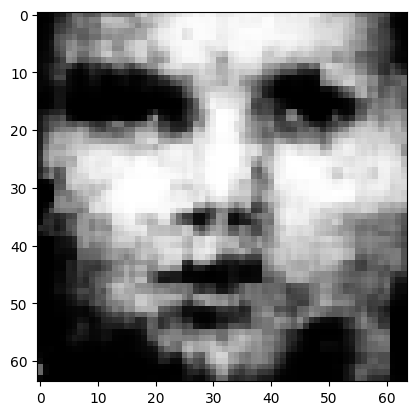

loss(generator):  0.14803513884544373
loss(generator):  0.14802208542823792
loss(generator):  0.14800995588302612
loss(generator):  0.14799864590168
loss(generator):  0.14798662066459656
loss(generator):  0.14797531068325043
loss(generator):  0.1479640007019043
loss(generator):  0.14795289933681488
loss(generator):  0.14794190227985382
loss(generator):  0.1479307860136032
loss(generator):  0.1479198932647705
loss(generator):  0.14790908992290497
loss(generator):  0.14789830148220062
loss(generator):  0.14788812398910522
loss(generator):  0.1478775292634964
loss(generator):  0.14786703884601593
loss(generator):  0.1478569656610489
loss(generator):  0.1478467881679535
loss(generator):  0.14783671498298645
loss(generator):  0.14782673120498657
loss(generator):  0.1478169709444046
loss(generator):  0.14780740439891815
loss(generator):  0.1477978378534317
loss(generator):  0.14778827130794525
loss(generator):  0.14777891337871552
loss(generator):  0.14776955544948578
loss(generator):  0.147

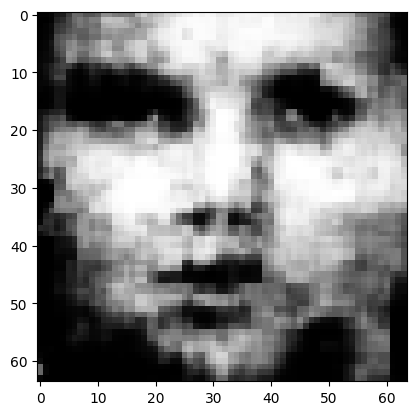

loss(generator):  0.1470085084438324
loss(generator):  0.1470070630311966
loss(generator):  0.14700552821159363
loss(generator):  0.14700408279895782
loss(generator):  0.14700233936309814
loss(generator):  0.14700068533420563
loss(generator):  0.14699923992156982
loss(generator):  0.14699770510196686
loss(generator):  0.14699646830558777
loss(generator):  0.14699512720108032
loss(generator):  0.14699317514896393
loss(generator):  0.14699214696884155
loss(generator):  0.1469905972480774
loss(generator):  0.14698927104473114
loss(generator):  0.14698803424835205
loss(generator):  0.1469866931438446
loss(generator):  0.14698514342308044
loss(generator):  0.14698390662670135
loss(generator):  0.14698268473148346
loss(generator):  0.146981343626976
loss(generator):  0.14698021113872528
loss(generator):  0.14697866141796112
loss(generator):  0.14697742462158203
loss(generator):  0.14697599411010742
loss(generator):  0.14697475731372833
loss(generator):  0.14697372913360596
loss(generator):  

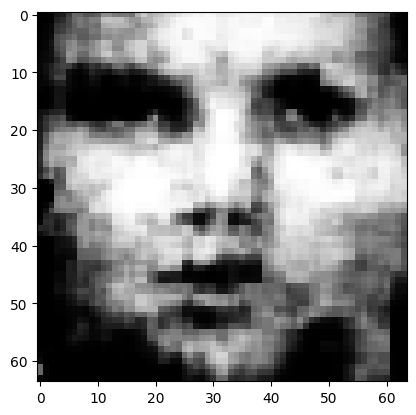

loss(generator):  0.1468721479177475
loss(generator):  0.14687204360961914
loss(generator):  0.1468716263771057
loss(generator):  0.146871417760849
loss(generator):  0.146871417760849
loss(generator):  0.14687101542949677
loss(generator):  0.1468707025051117
loss(generator):  0.14687059819698334
loss(generator):  0.14687038958072662
loss(generator):  0.14687007665634155
loss(generator):  0.1468699872493744
loss(generator):  0.14686988294124603
loss(generator):  0.14686957001686096
loss(generator):  0.14686936140060425
loss(generator):  0.1468692570924759
loss(generator):  0.14686904847621918
loss(generator):  0.14686864614486694
loss(generator):  0.14686864614486694
loss(generator):  0.14686843752861023
loss(generator):  0.14686822891235352
loss(generator):  0.14686822891235352
loss(generator):  0.14686822891235352
loss(generator):  0.14686791598796844
loss(generator):  0.14686761796474457
loss(generator):  0.1468675136566162
loss(generator):  0.14686709642410278
loss(generator):  0.14

In [176]:
z2 = torch.normal(0, 1, size=(1,64)).to(device)
z2.requires_grad_(True)
optimize_z_eps(z2, 1000, 1, 0.0001, 0.99, target=8)

In [177]:
torch.softmax(classifier(decoder(z2)),-1)

tensor([[4.7840e-05, 4.0221e-06, 9.0823e-04, 1.2859e-03, 4.0909e-04, 9.4827e-06,
         1.1241e-02, 1.1417e-05, 8.6342e-01, 7.4488e-03, 1.6448e-04, 4.3399e-04,
         2.4690e-03, 2.1292e-05, 3.7892e-04, 5.1381e-05, 6.2303e-03, 4.0703e-04,
         1.2908e-04, 3.7772e-04, 6.3811e-03, 1.5275e-03, 8.1710e-03, 1.7051e-03,
         4.9192e-03, 2.8526e-05, 4.3158e-05, 4.6484e-03, 1.7316e-02, 1.8594e-03,
         3.0622e-03, 3.2079e-06, 6.0139e-03, 5.0177e-05, 1.8443e-02, 1.2848e-04,
         6.2919e-04, 1.8751e-02, 5.4924e-03, 5.3778e-03]],
       grad_fn=<SoftmaxBackward>)

loss(generator):  18.034170150756836


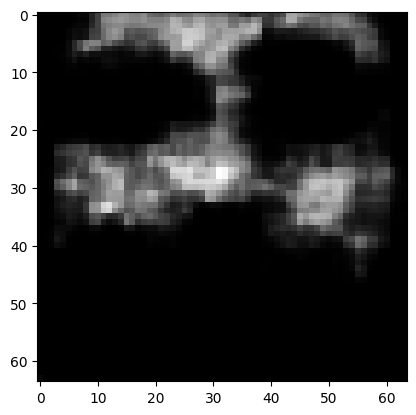

loss(generator):  17.015398025512695
loss(generator):  15.449724197387695
loss(generator):  14.506158828735352
loss(generator):  13.40963363647461
loss(generator):  12.643864631652832
loss(generator):  11.787447929382324
loss(generator):  11.396162986755371
loss(generator):  11.16874885559082
loss(generator):  10.897782325744629
loss(generator):  10.573357582092285
loss(generator):  10.300254821777344
loss(generator):  10.132129669189453
loss(generator):  9.903128623962402
loss(generator):  9.56495189666748
loss(generator):  9.297891616821289
loss(generator):  8.994282722473145
loss(generator):  8.692215919494629
loss(generator):  8.394974708557129
loss(generator):  8.13550090789795
loss(generator):  7.7935404777526855
loss(generator):  7.421798229217529
loss(generator):  6.942824840545654
loss(generator):  6.3931732177734375
loss(generator):  5.868810176849365
loss(generator):  5.228619575500488
loss(generator):  4.524453639984131
loss(generator):  3.8281378746032715
loss(generator): 

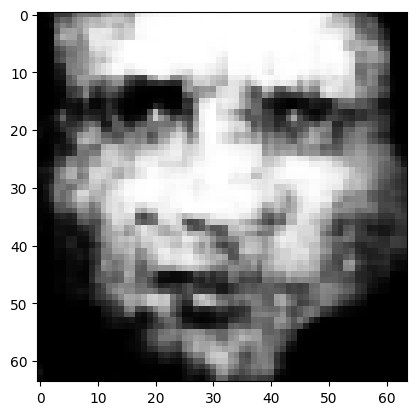

loss(generator):  0.08399534970521927
loss(generator):  0.08392662554979324
loss(generator):  0.08385493606328964
loss(generator):  0.0837857648730278
loss(generator):  0.08371713012456894
loss(generator):  0.08364740014076233
loss(generator):  0.08357974886894226
loss(generator):  0.08351285755634308
loss(generator):  0.08344552665948868
loss(generator):  0.08338115364313126
loss(generator):  0.08331622183322906
loss(generator):  0.08325140178203583
loss(generator):  0.08318525552749634
loss(generator):  0.0831202045083046
loss(generator):  0.08306173235177994
loss(generator):  0.0829954668879509
loss(generator):  0.08293238282203674
loss(generator):  0.0828719213604927
loss(generator):  0.08281123638153076
loss(generator):  0.0827513262629509
loss(generator):  0.0826927199959755
loss(generator):  0.08263411372900009
loss(generator):  0.08257901668548584
loss(generator):  0.08252259343862534
loss(generator):  0.08246847987174988
loss(generator):  0.08241095393896103
loss(generator):  

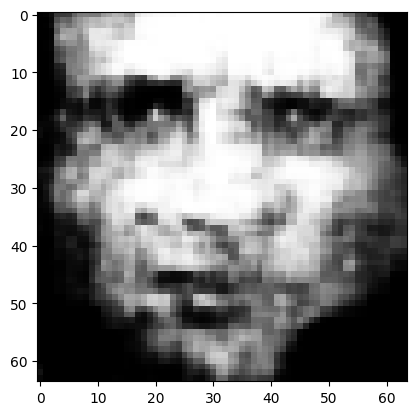

loss(generator):  0.07744409143924713
loss(generator):  0.07743250578641891
loss(generator):  0.07742136716842651
loss(generator):  0.07741132378578186
loss(generator):  0.07739973813295364
loss(generator):  0.07738881558179855
loss(generator):  0.07737745344638824
loss(generator):  0.07736697047948837
loss(generator):  0.07735604792833328
loss(generator):  0.0773453488945961
loss(generator):  0.07733442634344101
loss(generator):  0.07732482254505157
loss(generator):  0.07731389999389648
loss(generator):  0.07730341702699661
loss(generator):  0.07729337364435196
loss(generator):  0.07728377729654312
loss(generator):  0.0772743970155716
loss(generator):  0.07726424932479858
loss(generator):  0.07725376635789871
loss(generator):  0.07724515348672867
loss(generator):  0.07723500579595566
loss(generator):  0.07722529023885727
loss(generator):  0.07721590995788574
loss(generator):  0.07720708847045898
loss(generator):  0.07719781249761581
loss(generator):  0.07718909531831741
loss(generator

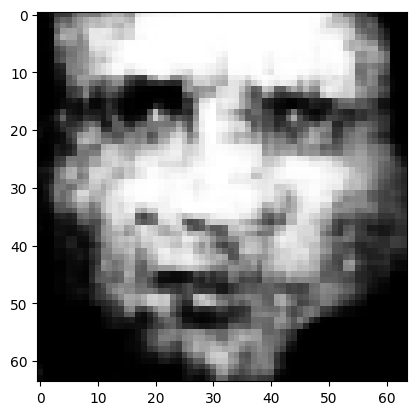

loss(generator):  0.07648346573114395
loss(generator):  0.07648192346096039
loss(generator):  0.07648070901632309
loss(generator):  0.07647949457168579
loss(generator):  0.07647772878408432
loss(generator):  0.07647650688886642
loss(generator):  0.07647507637739182
loss(generator):  0.07647375017404556
loss(generator):  0.07647231221199036
loss(generator):  0.07647120952606201
loss(generator):  0.07646999508142471
loss(generator):  0.07646878063678741
loss(generator):  0.07646756619215012
loss(generator):  0.07646623998880386
loss(generator):  0.07646524906158447
loss(generator):  0.07646381109952927
loss(generator):  0.07646303623914719
loss(generator):  0.07646159827709198
loss(generator):  0.07646049559116364
loss(generator):  0.07645939290523529
loss(generator):  0.07645806670188904
loss(generator):  0.07645707577466965
loss(generator):  0.07645586133003235
loss(generator):  0.07645486295223236
loss(generator):  0.07645376026630402
loss(generator):  0.07645276933908463
loss(generat

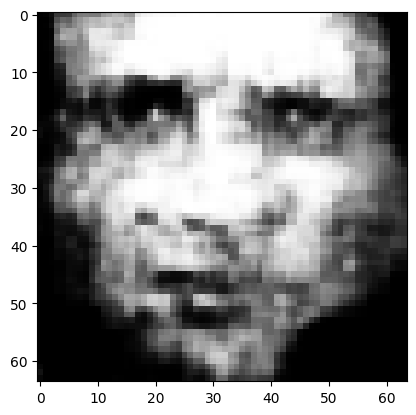

loss(generator):  0.07636463642120361
loss(generator):  0.0763644129037857
loss(generator):  0.0763641968369484
loss(generator):  0.07636408507823944
loss(generator):  0.07636386156082153
loss(generator):  0.07636374980211258
loss(generator):  0.07636342197656631
loss(generator):  0.07636319845914841
loss(generator):  0.07636319845914841
loss(generator):  0.07636287063360214
loss(generator):  0.07636264711618423
loss(generator):  0.07636253535747528
loss(generator):  0.07636231929063797
loss(generator):  0.07636220753192902
loss(generator):  0.07636209577322006
loss(generator):  0.07636198401451111
loss(generator):  0.07636198401451111
loss(generator):  0.0763617679476738
loss(generator):  0.07636165618896484
loss(generator):  0.07636143267154694
loss(generator):  0.07636132091283798
loss(generator):  0.07636099308729172
loss(generator):  0.07636088132858276
loss(generator):  0.07636088132858276
loss(generator):  0.07636044174432755
loss(generator):  0.07636032998561859
loss(generator)

In [178]:
attack0 = torch.normal(0, 1, size=(1,64)).to(device)
attack0.requires_grad_(True)
optimize_z_eps(attack0, 1000, 1, 0.0001, 0.99, target=0)

In [179]:
torch.softmax(classifier(decoder(attack0)),-1)

tensor([[9.2649e-01, 2.8186e-05, 2.6415e-04, 8.3120e-05, 7.5125e-05, 4.1861e-06,
         1.6517e-04, 1.5974e-04, 3.2451e-04, 1.9928e-03, 7.3103e-07, 4.0061e-03,
         7.6425e-03, 9.8679e-05, 3.4107e-07, 3.0652e-06, 7.6304e-03, 1.9801e-06,
         6.4888e-06, 9.4776e-07, 2.3132e-03, 7.0764e-04, 2.4250e-04, 7.5630e-05,
         7.5032e-04, 2.6458e-04, 1.6873e-05, 6.7110e-04, 2.3892e-03, 6.6225e-06,
         8.4868e-04, 1.3437e-06, 3.2489e-04, 9.0552e-06, 3.4029e-03, 1.0218e-06,
         2.5925e-02, 9.9689e-03, 9.2070e-04, 2.1785e-03]],
       grad_fn=<SoftmaxBackward>)

loss(generator):  7.632225036621094


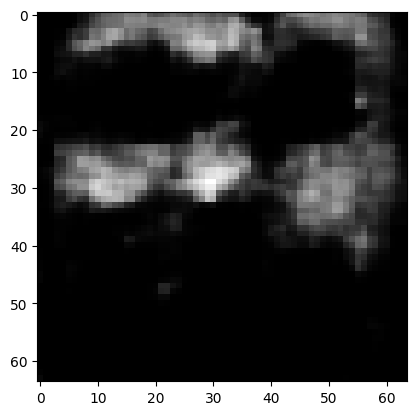

loss(generator):  7.331987380981445
loss(generator):  7.219561576843262
loss(generator):  7.112295150756836
loss(generator):  7.0124616622924805
loss(generator):  6.906630516052246
loss(generator):  6.810357093811035
loss(generator):  6.683479309082031
loss(generator):  6.579886436462402
loss(generator):  6.462588787078857
loss(generator):  6.348795413970947
loss(generator):  6.231708526611328
loss(generator):  6.110160827636719
loss(generator):  5.96421480178833
loss(generator):  5.7928924560546875
loss(generator):  5.637712001800537
loss(generator):  5.4791364669799805
loss(generator):  5.358866214752197
loss(generator):  5.24247932434082
loss(generator):  5.114268779754639
loss(generator):  5.013122081756592
loss(generator):  4.937137603759766
loss(generator):  4.837594032287598
loss(generator):  4.738654136657715
loss(generator):  4.654338836669922
loss(generator):  4.5981292724609375
loss(generator):  4.536332130432129
loss(generator):  4.486474514007568
loss(generator):  4.440329

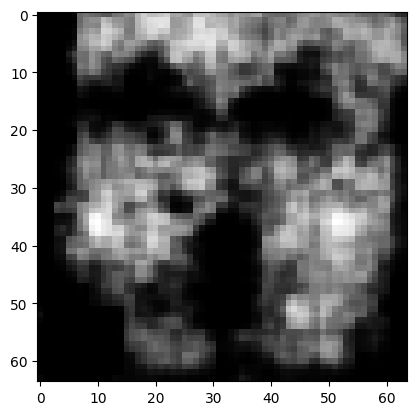

loss(generator):  1.7095611095428467
loss(generator):  1.7035579681396484
loss(generator):  1.6963846683502197
loss(generator):  1.6895864009857178
loss(generator):  1.6829572916030884
loss(generator):  1.6766384840011597
loss(generator):  1.6711513996124268
loss(generator):  1.665619134902954
loss(generator):  1.6603381633758545
loss(generator):  1.6551754474639893
loss(generator):  1.6500638723373413
loss(generator):  1.6449005603790283
loss(generator):  1.6399974822998047
loss(generator):  1.635626196861267
loss(generator):  1.6313310861587524
loss(generator):  1.6271402835845947
loss(generator):  1.6232213973999023
loss(generator):  1.6194020509719849
loss(generator):  1.6157491207122803
loss(generator):  1.612568974494934
loss(generator):  1.6088837385177612
loss(generator):  1.6055428981781006
loss(generator):  1.6021521091461182
loss(generator):  1.5986759662628174
loss(generator):  1.5951627492904663
loss(generator):  1.5916036367416382
loss(generator):  1.5883500576019287
loss

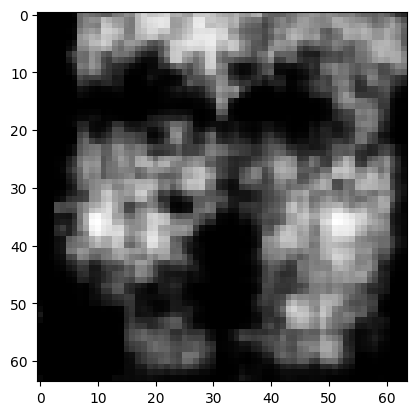

loss(generator):  1.4103879928588867
loss(generator):  1.4100736379623413
loss(generator):  1.4097422361373901
loss(generator):  1.4094429016113281
loss(generator):  1.409141182899475
loss(generator):  1.4088302850723267
loss(generator):  1.408524513244629
loss(generator):  1.4082601070404053
loss(generator):  1.4079415798187256
loss(generator):  1.407645344734192
loss(generator):  1.4073728322982788
loss(generator):  1.4070922136306763
loss(generator):  1.4067981243133545
loss(generator):  1.4065256118774414
loss(generator):  1.4062588214874268
loss(generator):  1.4059879779815674
loss(generator):  1.4057284593582153
loss(generator):  1.4054429531097412
loss(generator):  1.405194640159607
loss(generator):  1.4049259424209595
loss(generator):  1.4046502113342285
loss(generator):  1.4043854475021362
loss(generator):  1.4041508436203003
loss(generator):  1.4038753509521484
loss(generator):  1.40362548828125
loss(generator):  1.4033887386322021
loss(generator):  1.4031208753585815
loss(ge

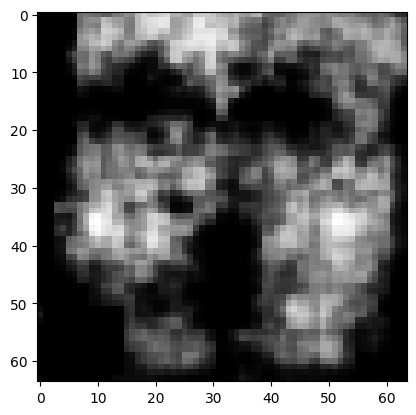

loss(generator):  1.3823095560073853
loss(generator):  1.382270097732544
loss(generator):  1.3822264671325684
loss(generator):  1.3821842670440674
loss(generator):  1.382145881652832
loss(generator):  1.3821074962615967
loss(generator):  1.3820648193359375
loss(generator):  1.3820269107818604
loss(generator):  1.3819892406463623
loss(generator):  1.3819499015808105
loss(generator):  1.381911277770996
loss(generator):  1.381874680519104
loss(generator):  1.3818366527557373
loss(generator):  1.3817988634109497
loss(generator):  1.3817635774612427
loss(generator):  1.3817274570465088
loss(generator):  1.381690502166748
loss(generator):  1.381655216217041
loss(generator):  1.3816207647323608
loss(generator):  1.381588101387024
loss(generator):  1.3815518617630005
loss(generator):  1.3815184831619263
loss(generator):  1.3814871311187744
loss(generator):  1.3814526796340942
loss(generator):  1.3814181089401245
loss(generator):  1.3813868761062622
loss(generator):  1.3813539743423462
loss(gen

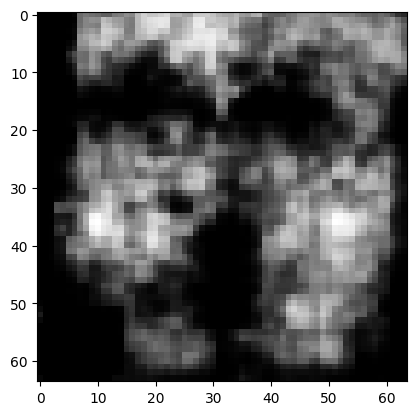

loss(generator):  1.3787347078323364
loss(generator):  1.3787288665771484
loss(generator):  1.3787240982055664
loss(generator):  1.3787180185317993
loss(generator):  1.3787132501602173
loss(generator):  1.3787084817886353
loss(generator):  1.378702998161316
loss(generator):  1.378697395324707
loss(generator):  1.378692865371704
loss(generator):  1.3786870241165161
loss(generator):  1.3786817789077759
loss(generator):  1.378677248954773
loss(generator):  1.3786729574203491
loss(generator):  1.3786667585372925
loss(generator):  1.3786616325378418
loss(generator):  1.3786572217941284
loss(generator):  1.3786535263061523
loss(generator):  1.378647804260254
loss(generator):  1.3786431550979614
loss(generator):  1.378639578819275
loss(generator):  1.3786343336105347
loss(generator):  1.3786301612854004
loss(generator):  1.3786253929138184
loss(generator):  1.378621220588684
loss(generator):  1.3786168098449707
loss(generator):  1.3786125183105469
loss(generator):  1.3786078691482544
loss(gen

In [180]:
attack1 = torch.normal(0, 1, size=(1,64)).to(device)
attack1.requires_grad_(True)
optimize_z_eps(attack1, 1000, 1, 0.0001, 0.99, target=1)

In [181]:
torch.softmax(classifier(decoder(attack1)),-1)

tensor([[4.6009e-05, 2.5202e-01, 4.6075e-05, 2.3342e-04, 3.4897e-05, 5.5375e-09,
         7.3951e-06, 3.5420e-07, 2.1107e-05, 1.2886e-05, 5.1261e-04, 5.7793e-05,
         5.1573e-02, 4.4231e-03, 2.4039e-04, 2.9372e-03, 2.5788e-04, 4.8330e-07,
         1.7716e-04, 1.2409e-02, 6.2270e-02, 7.3642e-02, 5.1477e-08, 5.0802e-03,
         7.9301e-06, 2.0449e-08, 6.5695e-04, 7.6933e-04, 4.3703e-02, 3.1323e-02,
         1.1464e-01, 1.1197e-06, 3.5810e-03, 2.0234e-01, 2.7325e-05, 6.6656e-03,
         2.9026e-03, 5.1917e-04, 4.1686e-02, 8.5176e-02]],
       grad_fn=<SoftmaxBackward>)

loss(generator):  10.225898742675781


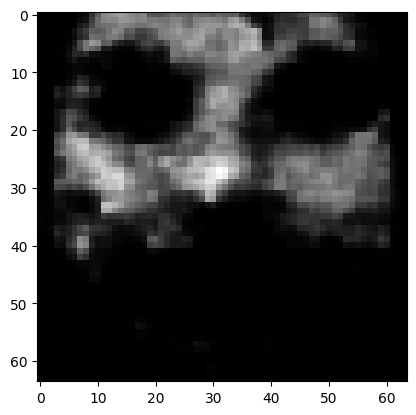

loss(generator):  8.591196060180664
loss(generator):  7.57377290725708
loss(generator):  6.665173530578613
loss(generator):  5.788873195648193
loss(generator):  4.8210129737854
loss(generator):  4.006748199462891
loss(generator):  3.1880252361297607
loss(generator):  2.677539348602295
loss(generator):  2.226069927215576
loss(generator):  1.8537870645523071
loss(generator):  1.5865751504898071
loss(generator):  1.3798396587371826
loss(generator):  1.2138797044754028
loss(generator):  1.0659008026123047
loss(generator):  0.923785924911499
loss(generator):  0.820051372051239
loss(generator):  0.7518137097358704
loss(generator):  0.6970851421356201
loss(generator):  0.6418465375900269
loss(generator):  0.5884488224983215
loss(generator):  0.5433921813964844
loss(generator):  0.49733859300613403
loss(generator):  0.44682133197784424
loss(generator):  0.39383500814437866
loss(generator):  0.3399345278739929
loss(generator):  0.2989642322063446
loss(generator):  0.26477521657943726
loss(gener

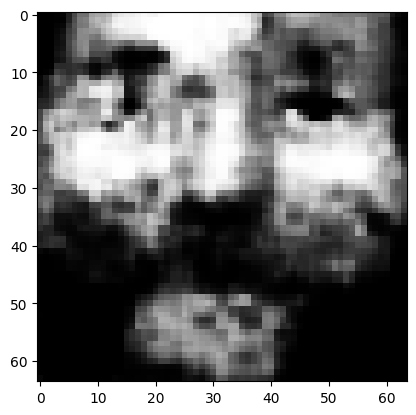

loss(generator):  0.03297504782676697
loss(generator):  0.03294713422656059
loss(generator):  0.032918531447649
loss(generator):  0.03289107605814934
loss(generator):  0.03286385163664818
loss(generator):  0.03283755108714104
loss(generator):  0.03281078860163689
loss(generator):  0.032784368842840195
loss(generator):  0.03275841102004051
loss(generator):  0.03273245319724083
loss(generator):  0.03270765021443367
loss(generator):  0.032682497054338455
loss(generator):  0.032657690346241
loss(generator):  0.03263380751013756
loss(generator):  0.03260946273803711
loss(generator):  0.03258557617664337
loss(generator):  0.03256192430853844
loss(generator):  0.03253861516714096
loss(generator):  0.032515764236450195
loss(generator):  0.032492686063051224
loss(generator):  0.03247006610035896
loss(generator):  0.03244791179895401
loss(generator):  0.03242482990026474
loss(generator):  0.03240024670958519
loss(generator):  0.03237589821219444
loss(generator):  0.03235200420022011
loss(generat

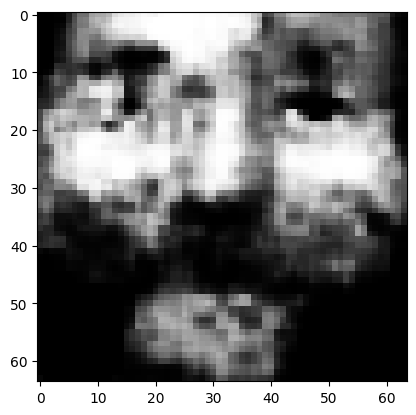

loss(generator):  0.030616631731390953
loss(generator):  0.030613278970122337
loss(generator):  0.030610157176852226
loss(generator):  0.030606919899582863
loss(generator):  0.0306036826223135
loss(generator):  0.030600329861044884
loss(generator):  0.030597323551774025
loss(generator):  0.03059408627450466
loss(generator):  0.030591079965233803
loss(generator):  0.03058795817196369
loss(generator):  0.030584951862692833
loss(generator):  0.030581945553421974
loss(generator):  0.03057870827615261
loss(generator):  0.030575934797525406
loss(generator):  0.030572928488254547
loss(generator):  0.030570153146982193
loss(generator):  0.030567262321710587
loss(generator):  0.030564717948436737
loss(generator):  0.030561713501811028
loss(generator):  0.030559169128537178
loss(generator):  0.03055616281926632
loss(generator):  0.030553502961993217
loss(generator):  0.030550729483366013
loss(generator):  0.030548300594091415
loss(generator):  0.030545640736818314
loss(generator):  0.03054298274

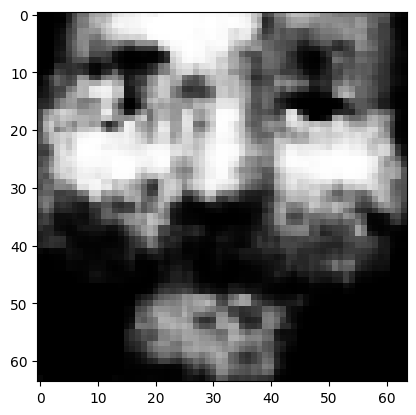

loss(generator):  0.030342817306518555
loss(generator):  0.030342470854520798
loss(generator):  0.030341893434524536
loss(generator):  0.030341660603880882
loss(generator):  0.030341198667883873
loss(generator):  0.03034096769988537
loss(generator):  0.03034062124788761
loss(generator):  0.030339926481246948
loss(generator):  0.03033958002924919
loss(generator):  0.03033946454524994
loss(generator):  0.030339118093252182
loss(generator):  0.03033853881061077
loss(generator):  0.030338192358613014
loss(generator):  0.030337845906615257
loss(generator):  0.0303373821079731
loss(generator):  0.030337035655975342
loss(generator):  0.030336804687976837
loss(generator):  0.03033634088933468
loss(generator):  0.03033599443733692
loss(generator):  0.030335763469338417
loss(generator):  0.03033541701734066
loss(generator):  0.030335186049342155
loss(generator):  0.0303349532186985
loss(generator):  0.030334491282701492
loss(generator):  0.030334144830703735
loss(generator):  0.03033379651606083

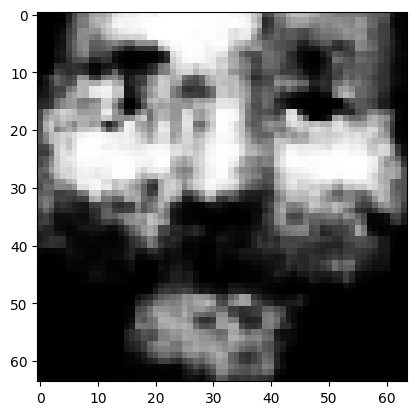

loss(generator):  0.03030765987932682
loss(generator):  0.03030765987932682
loss(generator):  0.03030765987932682
loss(generator):  0.030307428911328316
loss(generator):  0.030307428911328316
loss(generator):  0.030307428911328316
loss(generator):  0.030307313427329063
loss(generator):  0.030307313427329063
loss(generator):  0.030307313427329063
loss(generator):  0.03030719794332981
loss(generator):  0.03030708245933056
loss(generator):  0.03030708245933056
loss(generator):  0.03030708245933056
loss(generator):  0.030306966975331306
loss(generator):  0.030306966975331306
loss(generator):  0.030306966975331306
loss(generator):  0.030306736007332802
loss(generator):  0.030306736007332802
loss(generator):  0.03030662052333355
loss(generator):  0.030306505039334297
loss(generator):  0.030306505039334297
loss(generator):  0.030306505039334297
loss(generator):  0.030306505039334297
loss(generator):  0.030306387692689896
loss(generator):  0.030306387692689896
loss(generator):  0.0303063876926

In [183]:
attack2 = torch.normal(0, 1, size=(1,64)).to(device)
attack2.requires_grad_(True)
optimize_z_eps(attack2, 1000, 1, 0.0001, 0.99, target=2)

In [187]:
torch.softmax(classifier(decoder(attack2)),-1)

tensor([[1.2781e-08, 3.6320e-06, 9.7015e-01, 3.7669e-04, 1.0097e-06, 1.7685e-07,
         7.3738e-05, 1.1078e-05, 8.0793e-06, 6.3684e-06, 6.5086e-04, 1.4692e-07,
         1.8776e-06, 8.5062e-04, 2.0292e-07, 9.1683e-07, 3.3707e-04, 5.5867e-11,
         7.8501e-06, 1.1681e-04, 1.0980e-03, 7.2148e-03, 1.2295e-06, 7.1909e-08,
         4.2235e-05, 2.5899e-04, 1.8149e-05, 8.0772e-03, 1.6318e-04, 2.9649e-06,
         7.7096e-05, 2.8766e-07, 5.6274e-05, 1.0395e-03, 5.2016e-05, 3.4152e-07,
         7.5983e-03, 8.8689e-04, 3.1358e-04, 5.0005e-04]],
       grad_fn=<SoftmaxBackward>)

loss(generator):  11.828498840332031


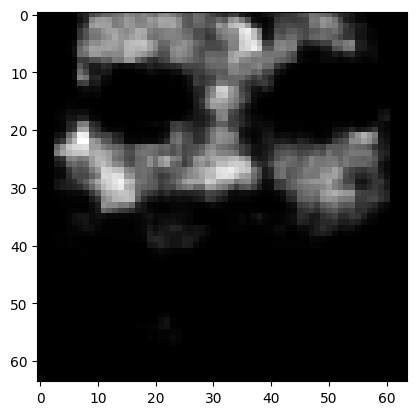

loss(generator):  11.170058250427246
loss(generator):  10.542936325073242
loss(generator):  9.836004257202148
loss(generator):  8.800058364868164
loss(generator):  8.114551544189453
loss(generator):  7.3240065574646
loss(generator):  6.632547378540039
loss(generator):  6.006754398345947
loss(generator):  5.375614166259766
loss(generator):  4.844080924987793
loss(generator):  4.366377353668213
loss(generator):  3.941826343536377
loss(generator):  3.368739366531372
loss(generator):  2.685586452484131
loss(generator):  2.0362157821655273
loss(generator):  1.4988653659820557
loss(generator):  1.0588940382003784
loss(generator):  0.8080027103424072
loss(generator):  0.6399561166763306
loss(generator):  0.5310521721839905
loss(generator):  0.4512536823749542
loss(generator):  0.4080278277397156
loss(generator):  0.3786250650882721
loss(generator):  0.3545484244823456
loss(generator):  0.33282893896102905
loss(generator):  0.3179319500923157
loss(generator):  0.3037092685699463
loss(generator

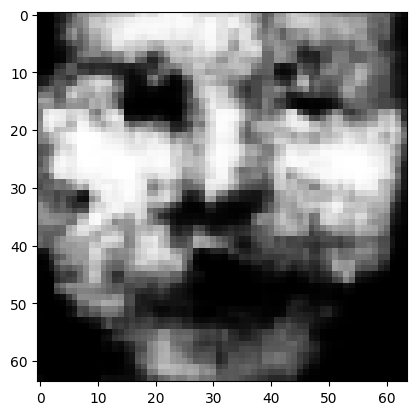

loss(generator):  0.10552877932786942
loss(generator):  0.10545744001865387
loss(generator):  0.1053648516535759
loss(generator):  0.10527483373880386
loss(generator):  0.10519994050264359
loss(generator):  0.10510518401861191
loss(generator):  0.1050502359867096
loss(generator):  0.10495289415121078
loss(generator):  0.10489761084318161
loss(generator):  0.10481517761945724
loss(generator):  0.10474314540624619
loss(generator):  0.10467658191919327
loss(generator):  0.10459744930267334
loss(generator):  0.10453785955905914
loss(generator):  0.10445796698331833
loss(generator):  0.10440502315759659
loss(generator):  0.10432028770446777
loss(generator):  0.10427410900592804
loss(generator):  0.10419494658708572
loss(generator):  0.10413619130849838
loss(generator):  0.1040719524025917
loss(generator):  0.10400287061929703
loss(generator):  0.10394883155822754
loss(generator):  0.10387437790632248
loss(generator):  0.10382816940546036
loss(generator):  0.10375316441059113
loss(generator)

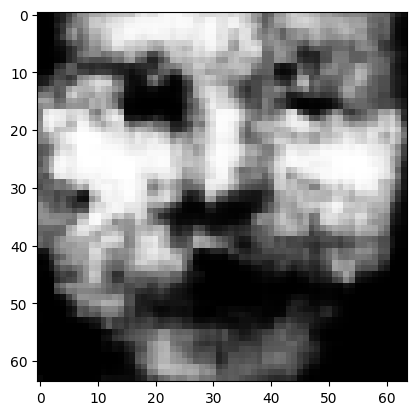

loss(generator):  0.09894856065511703
loss(generator):  0.09894122183322906
loss(generator):  0.09893063455820084
loss(generator):  0.09892070293426514
loss(generator):  0.09891282021999359
loss(generator):  0.09890148043632507
loss(generator):  0.09889532625675201
loss(generator):  0.0988839864730835
loss(generator):  0.0988759994506836
loss(generator):  0.09886714071035385
loss(generator):  0.09885699301958084
loss(generator):  0.0988502949476242
loss(generator):  0.09883993119001389
loss(generator):  0.09883280098438263
loss(generator):  0.09882373362779617
loss(generator):  0.0988152027130127
loss(generator):  0.09880785644054413
loss(generator):  0.09879802912473679
loss(generator):  0.09879154711961746
loss(generator):  0.09878291189670563
loss(generator):  0.09877491742372513
loss(generator):  0.09876778721809387
loss(generator):  0.0987582877278328
loss(generator):  0.09875266999006271
loss(generator):  0.09874337911605835
loss(generator):  0.09873668849468231
loss(generator): 

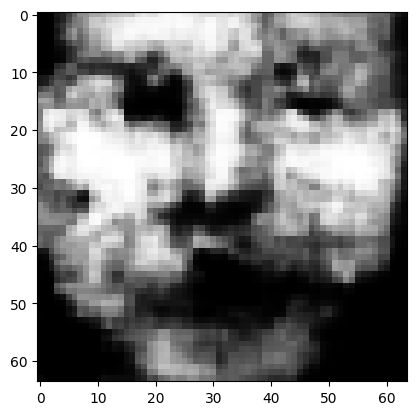

loss(generator):  0.09812229126691818
loss(generator):  0.09812121093273163
loss(generator):  0.09811991453170776
loss(generator):  0.09811840206384659
loss(generator):  0.0981176421046257
loss(generator):  0.09811602532863617
loss(generator):  0.09811516106128693
loss(generator):  0.09811386466026306
loss(generator):  0.09811267256736755
loss(generator):  0.09811192005872726
loss(generator):  0.09811072796583176
loss(generator):  0.09810932725667953
loss(generator):  0.09810835123062134
loss(generator):  0.09810705482959747
loss(generator):  0.09810619056224823
loss(generator):  0.09810511022806168
loss(generator):  0.09810391813516617
loss(generator):  0.09810316562652588
loss(generator):  0.09810175746679306
loss(generator):  0.0981006771326065
loss(generator):  0.0980997085571289
loss(generator):  0.09809873253107071
loss(generator):  0.09809786826372147
loss(generator):  0.0980965718626976
loss(generator):  0.09809592366218567
loss(generator):  0.09809494763612747
loss(generator):

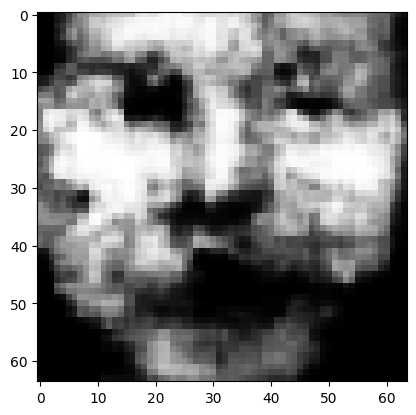

loss(generator):  0.09801573306322098
loss(generator):  0.09801551699638367
loss(generator):  0.09801540523767471
loss(generator):  0.09801530092954636
loss(generator):  0.09801508486270905
loss(generator):  0.09801497310400009
loss(generator):  0.09801475703716278
loss(generator):  0.09801475703716278
loss(generator):  0.09801443666219711
loss(generator):  0.09801432490348816
loss(generator):  0.0980142205953598
loss(generator):  0.09801400452852249
loss(generator):  0.09801389276981354
loss(generator):  0.09801346063613892
loss(generator):  0.09801346063613892
loss(generator):  0.09801346063613892
loss(generator):  0.09801314026117325
loss(generator):  0.09801314026117325
loss(generator):  0.0980130285024643
loss(generator):  0.09801270812749863
loss(generator):  0.09801259636878967
loss(generator):  0.09801238030195236
loss(generator):  0.09801216423511505
loss(generator):  0.09801216423511505
loss(generator):  0.09801194816827774
loss(generator):  0.09801194816827774
loss(generator

In [185]:
attack3 = torch.normal(0, 1, size=(1,64)).to(device)
attack3.requires_grad_(True)
optimize_z_eps(attack3, 1000, 1, 0.0001, 0.99, target=3)

In [188]:
torch.softmax(classifier(decoder(attack3)),-1)

tensor([[2.9696e-07, 2.1649e-04, 1.3753e-02, 9.0665e-01, 7.5667e-07, 2.0701e-06,
         2.6866e-03, 1.7383e-06, 7.2161e-04, 3.5777e-06, 1.1570e-03, 9.4234e-06,
         3.7019e-04, 2.3805e-03, 4.2175e-05, 1.0109e-05, 7.8495e-04, 4.4210e-07,
         3.4493e-04, 1.9336e-04, 3.5651e-03, 3.4052e-03, 6.8668e-05, 1.3472e-05,
         2.4412e-04, 1.6621e-03, 2.4558e-03, 3.9690e-02, 1.2804e-03, 7.1292e-07,
         9.6161e-05, 1.5075e-04, 1.2493e-04, 1.0483e-03, 1.3854e-06, 9.9272e-07,
         7.0233e-03, 9.2180e-03, 5.5441e-04, 6.9001e-05]],
       grad_fn=<SoftmaxBackward>)

loss(generator):  15.095849990844727


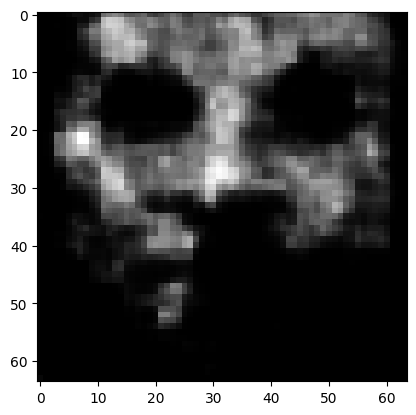

loss(generator):  13.308454513549805
loss(generator):  11.18716049194336
loss(generator):  9.622054100036621
loss(generator):  8.336034774780273
loss(generator):  7.301662445068359
loss(generator):  6.423264980316162
loss(generator):  5.494968414306641
loss(generator):  4.266600608825684
loss(generator):  2.960111618041992
loss(generator):  2.0352766513824463
loss(generator):  1.3601140975952148
loss(generator):  0.8477845191955566
loss(generator):  0.5402654409408569
loss(generator):  0.35695531964302063
loss(generator):  0.25183868408203125
loss(generator):  0.1997731626033783
loss(generator):  0.1690549999475479
loss(generator):  0.14878369867801666
loss(generator):  0.1351422220468521
loss(generator):  0.12484374642372131
loss(generator):  0.11575346440076828
loss(generator):  0.10675583779811859
loss(generator):  0.09959589689970016
loss(generator):  0.0934203565120697
loss(generator):  0.0881967768073082
loss(generator):  0.08337270468473434
loss(generator):  0.07888093590736389


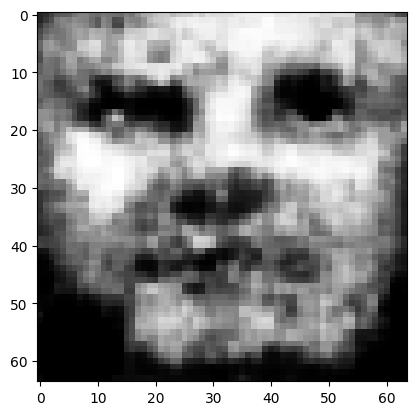

loss(generator):  0.02028762549161911
loss(generator):  0.020268935710191727
loss(generator):  0.020249776542186737
loss(generator):  0.020231086760759354
loss(generator):  0.020212627947330475
loss(generator):  0.020194636657834053
loss(generator):  0.020176295191049576
loss(generator):  0.020158536732196808
loss(generator):  0.02014077827334404
loss(generator):  0.02012348733842373
loss(generator):  0.020106429234147072
loss(generator):  0.02008960396051407
loss(generator):  0.02007313072681427
loss(generator):  0.020056890323758125
loss(generator):  0.020040882751345634
loss(generator):  0.02002534084022045
loss(generator):  0.020009450614452362
loss(generator):  0.019994376227259636
loss(generator):  0.019979186356067657
loss(generator):  0.01996457949280739
loss(generator):  0.019950207322835922
loss(generator):  0.019935600459575653
loss(generator):  0.019921693950891495
loss(generator):  0.019907554611563683
loss(generator):  0.019893880933523178
loss(generator):  0.019879974424

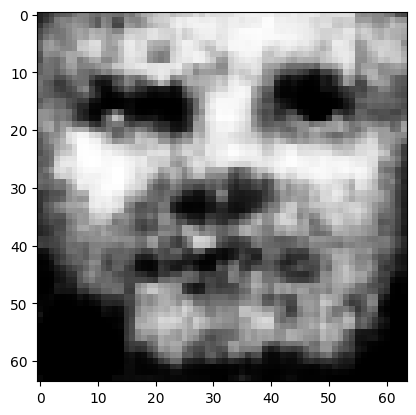

loss(generator):  0.018898196518421173
loss(generator):  0.018896207213401794
loss(generator):  0.01889456994831562
loss(generator):  0.018892697989940643
loss(generator):  0.018890943378210068
loss(generator):  0.018889188766479492
loss(generator):  0.018887551501393318
loss(generator):  0.018885912373661995
loss(generator):  0.01888415776193142
loss(generator):  0.018882520496845245
loss(generator):  0.01888088323175907
loss(generator):  0.018879128620028496
loss(generator):  0.018877491354942322
loss(generator):  0.018875852227211
loss(generator):  0.018874332308769226
loss(generator):  0.018872812390327454
loss(generator):  0.018871290609240532
loss(generator):  0.01886977069079876
loss(generator):  0.018868248909711838
loss(generator):  0.018866611644625664
loss(generator):  0.018865207210183144
loss(generator):  0.01886368729174137
loss(generator):  0.018862050026655197
loss(generator):  0.018860645592212677
loss(generator):  0.018859123811125755
loss(generator):  0.0188578385859

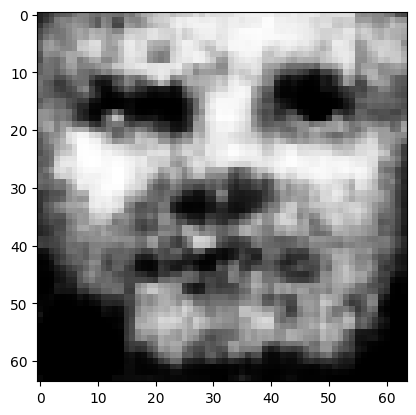

loss(generator):  0.01874845288693905
loss(generator):  0.018748220056295395
loss(generator):  0.018748102709650993
loss(generator):  0.01874786801636219
loss(generator):  0.018747635185718536
loss(generator):  0.018747400492429733
loss(generator):  0.01874728314578533
loss(generator):  0.018747050315141678
loss(generator):  0.018746932968497276
loss(generator):  0.018746698275208473
loss(generator):  0.01874658092856407
loss(generator):  0.018746348097920418
loss(generator):  0.018746113404631615
loss(generator):  0.01874587871134281
loss(generator):  0.018745645880699158
loss(generator):  0.018745528534054756
loss(generator):  0.018745411187410355
loss(generator):  0.0187451783567667
loss(generator):  0.018744943663477898
loss(generator):  0.018744826316833496
loss(generator):  0.018744708970189095
loss(generator):  0.01874447613954544
loss(generator):  0.018744241446256638
loss(generator):  0.018744124099612236
loss(generator):  0.018744006752967834
loss(generator):  0.0187437739223

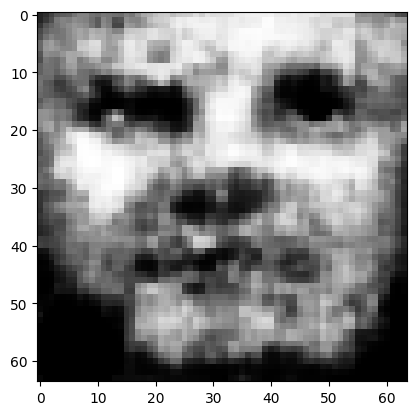

loss(generator):  0.01872985064983368
loss(generator):  0.01872985064983368
loss(generator):  0.01872985064983368
loss(generator):  0.018729733303189278
loss(generator):  0.018729733303189278
loss(generator):  0.018729617819190025
loss(generator):  0.018729617819190025
loss(generator):  0.018729617819190025
loss(generator):  0.018729617819190025
loss(generator):  0.018729617819190025
loss(generator):  0.018729500472545624
loss(generator):  0.018729500472545624
loss(generator):  0.018729500472545624
loss(generator):  0.018729500472545624
loss(generator):  0.018729500472545624
loss(generator):  0.018729500472545624
loss(generator):  0.018729500472545624
loss(generator):  0.018729383125901222
loss(generator):  0.018729383125901222
loss(generator):  0.018729383125901222
loss(generator):  0.018729383125901222
loss(generator):  0.018729383125901222
loss(generator):  0.018729383125901222
loss(generator):  0.018729383125901222
loss(generator):  0.018729383125901222
loss(generator):  0.01872926

In [186]:
attack4 = torch.normal(0, 1, size=(1,64)).to(device)
attack4.requires_grad_(True)
optimize_z_eps(attack4, 1000, 1, 0.0001, 0.99, target=4)

In [189]:
torch.softmax(classifier(decoder(attack4)),-1)

tensor([[2.8237e-06, 3.2623e-06, 1.3675e-05, 1.2488e-05, 9.8145e-01, 3.9273e-06,
         7.3472e-05, 8.6355e-08, 1.5726e-04, 5.1701e-05, 5.1101e-06, 1.3653e-03,
         1.9279e-05, 3.9998e-05, 1.0428e-05, 4.4761e-06, 1.0585e-03, 7.8656e-06,
         1.8626e-05, 3.4195e-06, 2.9114e-04, 8.1847e-04, 6.3958e-04, 4.9993e-06,
         1.5548e-04, 3.0920e-04, 1.5941e-06, 3.6051e-05, 2.2124e-07, 1.4536e-04,
         1.0060e-02, 4.1177e-04, 1.4824e-04, 2.6070e-05, 3.3215e-04, 1.5434e-03,
         4.1365e-05, 1.6317e-04, 3.7177e-05, 5.3591e-04]],
       grad_fn=<SoftmaxBackward>)

loss(generator):  24.39780616760254


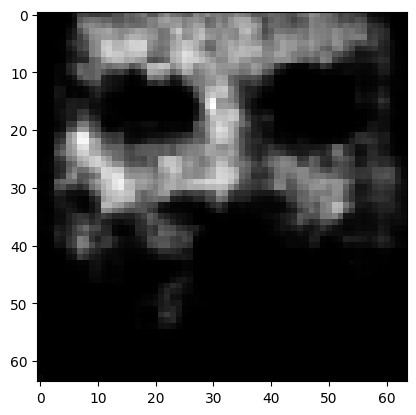

loss(generator):  22.091642379760742
loss(generator):  20.13309097290039
loss(generator):  18.340438842773438
loss(generator):  16.320951461791992
loss(generator):  14.242385864257812
loss(generator):  12.846776962280273
loss(generator):  12.068516731262207
loss(generator):  11.437551498413086
loss(generator):  10.898456573486328
loss(generator):  10.407270431518555
loss(generator):  9.963881492614746
loss(generator):  9.519432067871094
loss(generator):  9.076410293579102
loss(generator):  8.740287780761719
loss(generator):  8.441052436828613
loss(generator):  8.154643058776855
loss(generator):  7.872689247131348
loss(generator):  7.6329193115234375
loss(generator):  7.429412364959717
loss(generator):  7.224185943603516
loss(generator):  7.013659477233887
loss(generator):  6.80714750289917
loss(generator):  6.5967912673950195
loss(generator):  6.388195991516113
loss(generator):  6.192183494567871
loss(generator):  6.01096248626709
loss(generator):  5.824099540710449
loss(generator):  5

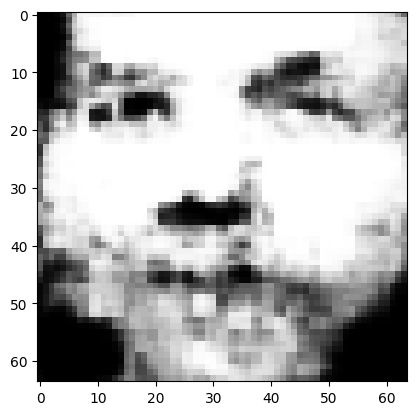

loss(generator):  1.242494821548462
loss(generator):  1.2409127950668335
loss(generator):  1.2393803596496582
loss(generator):  1.2378405332565308
loss(generator):  1.236377239227295
loss(generator):  1.2348984479904175
loss(generator):  1.2334551811218262
loss(generator):  1.2319667339324951
loss(generator):  1.2304775714874268
loss(generator):  1.2288849353790283
loss(generator):  1.2273480892181396
loss(generator):  1.2258658409118652
loss(generator):  1.2243831157684326
loss(generator):  1.2228909730911255
loss(generator):  1.22148597240448
loss(generator):  1.2200251817703247
loss(generator):  1.2186055183410645
loss(generator):  1.2172232866287231
loss(generator):  1.2158185243606567
loss(generator):  1.2144664525985718
loss(generator):  1.2131197452545166
loss(generator):  1.211771845817566
loss(generator):  1.2104276418685913
loss(generator):  1.2091158628463745
loss(generator):  1.207822561264038
loss(generator):  1.2065218687057495
loss(generator):  1.2052409648895264
loss(ge

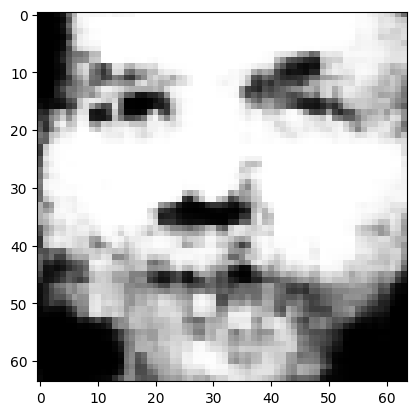

loss(generator):  1.095555067062378
loss(generator):  1.0953357219696045
loss(generator):  1.0951192378997803
loss(generator):  1.0949071645736694
loss(generator):  1.0946946144104004
loss(generator):  1.0944851636886597
loss(generator):  1.0942785739898682
loss(generator):  1.0940746068954468
loss(generator):  1.0938706398010254
loss(generator):  1.0936710834503174
loss(generator):  1.0934733152389526
loss(generator):  1.0932766199111938
loss(generator):  1.0930812358856201
loss(generator):  1.0928919315338135
loss(generator):  1.0927011966705322
loss(generator):  1.0925122499465942
loss(generator):  1.0923268795013428
loss(generator):  1.0921441316604614
loss(generator):  1.0919631719589233
loss(generator):  1.091790795326233
loss(generator):  1.0916200876235962
loss(generator):  1.091452956199646
loss(generator):  1.091286063194275
loss(generator):  1.0911200046539307
loss(generator):  1.0909565687179565
loss(generator):  1.090794563293457
loss(generator):  1.0906356573104858
loss(g

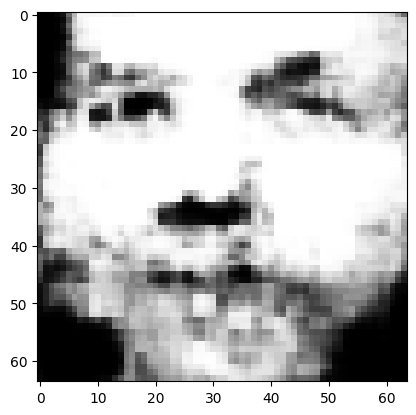

loss(generator):  1.0779762268066406
loss(generator):  1.077951192855835
loss(generator):  1.077926754951477
loss(generator):  1.0779024362564087
loss(generator):  1.0778789520263672
loss(generator):  1.0778560638427734
loss(generator):  1.0778323411941528
loss(generator):  1.0778099298477173
loss(generator):  1.0777872800827026
loss(generator):  1.077765703201294
loss(generator):  1.0777432918548584
loss(generator):  1.077721118927002
loss(generator):  1.0776994228363037
loss(generator):  1.0776771306991577
loss(generator):  1.0776562690734863
loss(generator):  1.0776346921920776
loss(generator):  1.077614665031433
loss(generator):  1.0775939226150513
loss(generator):  1.077573299407959
loss(generator):  1.0775526762008667
loss(generator):  1.0775326490402222
loss(generator):  1.077512502670288
loss(generator):  1.0774929523468018
loss(generator):  1.077473759651184
loss(generator):  1.0774542093276978
loss(generator):  1.0774357318878174
loss(generator):  1.0774157047271729
loss(gene

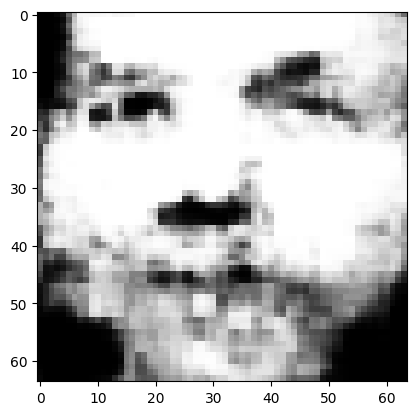

loss(generator):  1.0759145021438599
loss(generator):  1.0759103298187256
loss(generator):  1.0759073495864868
loss(generator):  1.0759049654006958
loss(generator):  1.075901985168457
loss(generator):  1.0758991241455078
loss(generator):  1.07589590549469
loss(generator):  1.075893521308899
loss(generator):  1.0758895874023438
loss(generator):  1.075886845588684
loss(generator):  1.0758843421936035
loss(generator):  1.0758814811706543
loss(generator):  1.0758787393569946
loss(generator):  1.0758755207061768
loss(generator):  1.0758728981018066
loss(generator):  1.0758707523345947
loss(generator):  1.0758670568466187
loss(generator):  1.075864315032959
loss(generator):  1.0758620500564575
loss(generator):  1.0758588314056396
loss(generator):  1.0758564472198486
loss(generator):  1.0758541822433472
loss(generator):  1.075852632522583
loss(generator):  1.0758497714996338
loss(generator):  1.0758475065231323
loss(generator):  1.0758445262908936
loss(generator):  1.0758423805236816
loss(gen

In [194]:
attack5 = torch.normal(0, 1, size=(1,64)).to(device)
attack5.requires_grad_(True)
optimize_z_eps(attack5, 1000, 1, 0.0001, 0.99, target=5)

In [195]:
torch.softmax(classifier(decoder(attack5)),-1)

tensor([[7.4647e-03, 3.5169e-04, 1.0507e-01, 1.8392e-01, 8.0884e-03, 3.4108e-01,
         6.8073e-02, 2.6389e-04, 1.0144e-02, 5.8457e-03, 4.4276e-04, 4.0193e-03,
         7.4684e-02, 5.6080e-03, 1.7906e-05, 2.8146e-03, 2.2582e-03, 2.7619e-03,
         3.9148e-04, 1.3012e-04, 3.1659e-04, 8.6402e-04, 5.9050e-02, 1.4145e-05,
         2.9103e-03, 2.2609e-02, 4.3132e-03, 2.3691e-02, 2.6928e-04, 1.3637e-05,
         3.5434e-04, 5.1550e-03, 6.3537e-04, 7.8516e-05, 1.9923e-05, 1.6575e-04,
         8.1170e-04, 3.8091e-02, 2.8634e-05, 1.7185e-02]],
       grad_fn=<SoftmaxBackward>)

loss(generator):  14.27963924407959


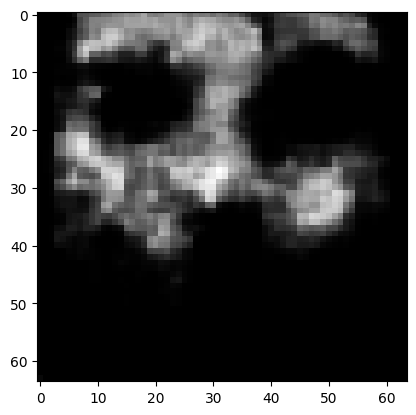

loss(generator):  12.98308277130127
loss(generator):  12.238831520080566
loss(generator):  11.69166088104248
loss(generator):  10.732754707336426
loss(generator):  9.560904502868652
loss(generator):  7.915320873260498
loss(generator):  6.730243682861328
loss(generator):  5.750746726989746
loss(generator):  4.900599002838135
loss(generator):  4.513465404510498
loss(generator):  4.202778339385986
loss(generator):  3.911952495574951
loss(generator):  3.691579818725586
loss(generator):  3.51248836517334
loss(generator):  3.398284912109375
loss(generator):  3.2843539714813232
loss(generator):  3.187613010406494
loss(generator):  3.102113962173462
loss(generator):  3.026322841644287
loss(generator):  2.9542860984802246
loss(generator):  2.888338088989258
loss(generator):  2.8135628700256348
loss(generator):  2.733978748321533
loss(generator):  2.642899751663208
loss(generator):  2.5484039783477783
loss(generator):  2.4430041313171387
loss(generator):  2.338700294494629
loss(generator):  2.22

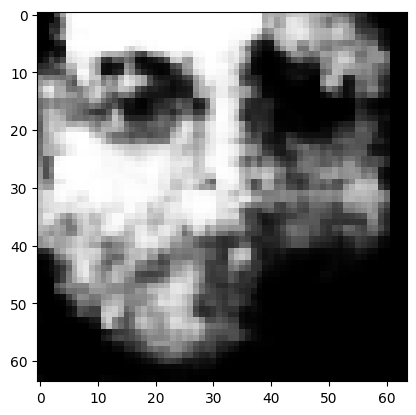

loss(generator):  0.4749334454536438
loss(generator):  0.47392040491104126
loss(generator):  0.47312888503074646
loss(generator):  0.4721904695034027
loss(generator):  0.4711752235889435
loss(generator):  0.47020554542541504
loss(generator):  0.4692813456058502
loss(generator):  0.46830064058303833
loss(generator):  0.46733537316322327
loss(generator):  0.466458797454834
loss(generator):  0.46550315618515015
loss(generator):  0.4645693600177765
loss(generator):  0.4637365937232971
loss(generator):  0.4628217816352844
loss(generator):  0.46198439598083496
loss(generator):  0.4611770808696747
loss(generator):  0.46043550968170166
loss(generator):  0.4597965180873871
loss(generator):  0.45913511514663696
loss(generator):  0.4584372639656067
loss(generator):  0.4577197730541229
loss(generator):  0.4570505917072296
loss(generator):  0.4564019441604614
loss(generator):  0.4557702839374542
loss(generator):  0.4550802707672119
loss(generator):  0.4543994069099426
loss(generator):  0.4537779092

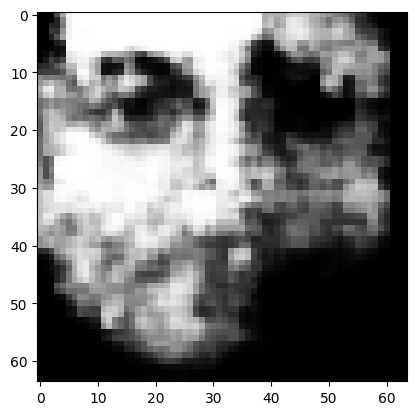

loss(generator):  0.4048207700252533
loss(generator):  0.4047335386276245
loss(generator):  0.40465113520622253
loss(generator):  0.40455153584480286
loss(generator):  0.4044630825519562
loss(generator):  0.40437406301498413
loss(generator):  0.4042852818965912
loss(generator):  0.4042007625102997
loss(generator):  0.40413162112236023
loss(generator):  0.40406349301338196
loss(generator):  0.403978168964386
loss(generator):  0.40389031171798706
loss(generator):  0.40381142497062683
loss(generator):  0.40372592210769653
loss(generator):  0.403646856546402
loss(generator):  0.4035639762878418
loss(generator):  0.40349000692367554
loss(generator):  0.40342843532562256
loss(generator):  0.40336599946022034
loss(generator):  0.4032820761203766
loss(generator):  0.40320202708244324
loss(generator):  0.40312978625297546
loss(generator):  0.40305250883102417
loss(generator):  0.40297913551330566
loss(generator):  0.4029107689857483
loss(generator):  0.40284454822540283
loss(generator):  0.4027

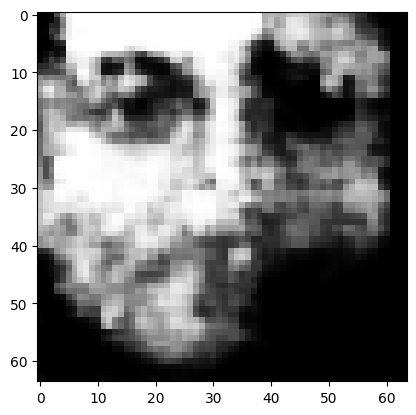

loss(generator):  0.3976534903049469
loss(generator):  0.39764299988746643
loss(generator):  0.3976321816444397
loss(generator):  0.39762216806411743
loss(generator):  0.3976123332977295
loss(generator):  0.3976020812988281
loss(generator):  0.39759284257888794
loss(generator):  0.3975825309753418
loss(generator):  0.3975752294063568
loss(generator):  0.3975687325000763
loss(generator):  0.39755865931510925
loss(generator):  0.39754968881607056
loss(generator):  0.39754006266593933
loss(generator):  0.3975314795970917
loss(generator):  0.3975217938423157
loss(generator):  0.397512823343277
loss(generator):  0.39750394225120544
loss(generator):  0.39749497175216675
loss(generator):  0.3974868059158325
loss(generator):  0.39747846126556396
loss(generator):  0.3974740505218506
loss(generator):  0.39746516942977905
loss(generator):  0.3974578082561493
loss(generator):  0.39744850993156433
loss(generator):  0.3974404036998749
loss(generator):  0.39743199944496155
loss(generator):  0.3974238

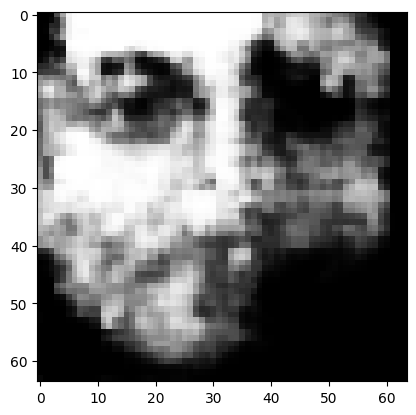

loss(generator):  0.3968002498149872
loss(generator):  0.39679890871047974
loss(generator):  0.39679786562919617
loss(generator):  0.3967968225479126
loss(generator):  0.3967958390712738
loss(generator):  0.39679479598999023
loss(generator):  0.3967933654785156
loss(generator):  0.39679208397865295
loss(generator):  0.3967908024787903
loss(generator):  0.3967896103858948
loss(generator):  0.3967881500720978
loss(generator):  0.3967874348163605
loss(generator):  0.39678606390953064
loss(generator):  0.3967851996421814
loss(generator):  0.3967837393283844
loss(generator):  0.39678269624710083
loss(generator):  0.39678189158439636
loss(generator):  0.3967812657356262
loss(generator):  0.3967798054218292
loss(generator):  0.3967784643173218
loss(generator):  0.3967772424221039
loss(generator):  0.39677613973617554
loss(generator):  0.396775484085083
loss(generator):  0.39677461981773376
loss(generator):  0.39677324891090393
loss(generator):  0.3967722952365875
loss(generator):  0.396771252

In [196]:
attack6 = torch.normal(0, 1, size=(1,64)).to(device)
attack6.requires_grad_(True)
optimize_z_eps(attack6, 1000, 1, 0.0001, 0.99, target=6)

In [199]:
torch.softmax(classifier(decoder(attack6)),-1)

tensor([[9.9897e-05, 1.5432e-04, 6.2271e-03, 7.5911e-04, 5.5998e-06, 2.6121e-06,
         6.7254e-01, 3.6242e-04, 1.4500e-03, 4.9584e-04, 3.8677e-04, 6.4354e-04,
         9.5897e-03, 2.1216e-03, 1.1724e-05, 4.6486e-05, 9.5604e-03, 8.0774e-07,
         5.1765e-04, 1.1177e-05, 1.6961e-04, 5.1728e-02, 8.5388e-05, 2.1974e-03,
         1.4689e-01, 1.5612e-03, 1.3904e-03, 3.0145e-02, 4.3513e-03, 2.6304e-05,
         1.5986e-02, 1.2109e-04, 2.6304e-03, 1.4561e-03, 1.8934e-03, 4.7943e-05,
         2.0797e-02, 5.9194e-03, 7.2064e-03, 4.0765e-04]],
       grad_fn=<SoftmaxBackward>)

loss(generator):  14.858027458190918


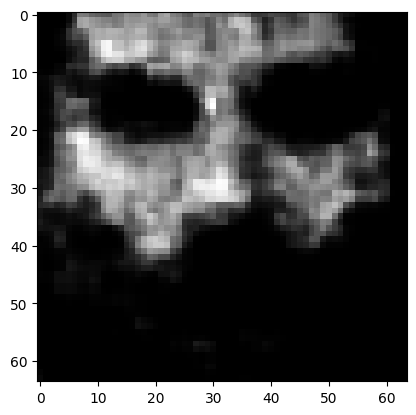

loss(generator):  13.462108612060547
loss(generator):  12.52067756652832
loss(generator):  11.672199249267578
loss(generator):  11.118987083435059
loss(generator):  10.683359146118164
loss(generator):  10.237691879272461
loss(generator):  9.739412307739258
loss(generator):  9.166892051696777
loss(generator):  8.60185432434082
loss(generator):  8.073837280273438
loss(generator):  7.7138214111328125
loss(generator):  7.423368453979492
loss(generator):  7.157761096954346
loss(generator):  6.890084266662598
loss(generator):  6.624612331390381
loss(generator):  6.3836750984191895
loss(generator):  6.174035549163818
loss(generator):  5.969923973083496
loss(generator):  5.784976959228516
loss(generator):  5.615995407104492
loss(generator):  5.424129009246826
loss(generator):  5.261124134063721
loss(generator):  5.106592178344727
loss(generator):  4.957486629486084
loss(generator):  4.821011543273926
loss(generator):  4.680966854095459
loss(generator):  4.534673690795898
loss(generator):  4.38

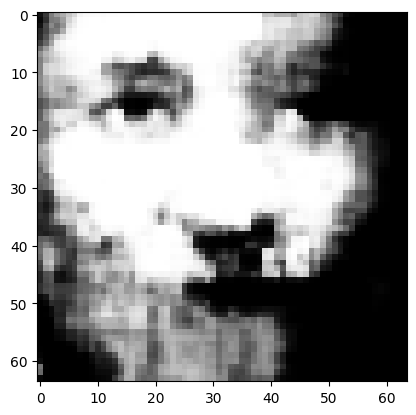

loss(generator):  0.6436989307403564
loss(generator):  0.6426771283149719
loss(generator):  0.6416739225387573
loss(generator):  0.640688955783844
loss(generator):  0.639712929725647
loss(generator):  0.6387670636177063
loss(generator):  0.6378293037414551
loss(generator):  0.6369049549102783
loss(generator):  0.6359922885894775
loss(generator):  0.6350861191749573
loss(generator):  0.6341908574104309
loss(generator):  0.6333063244819641
loss(generator):  0.6324362754821777
loss(generator):  0.6315794587135315
loss(generator):  0.6307435035705566
loss(generator):  0.6299349665641785
loss(generator):  0.6291385293006897
loss(generator):  0.6283590197563171
loss(generator):  0.6275810599327087
loss(generator):  0.6268161535263062
loss(generator):  0.626054048538208
loss(generator):  0.6253008246421814
loss(generator):  0.6245577931404114
loss(generator):  0.6238245368003845
loss(generator):  0.6230908632278442
loss(generator):  0.6223743557929993
loss(generator):  0.6216710209846497
loss

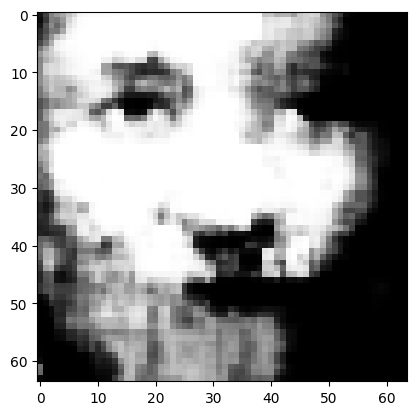

loss(generator):  0.5726844072341919
loss(generator):  0.572596549987793
loss(generator):  0.5725089311599731
loss(generator):  0.5724242329597473
loss(generator):  0.5723372101783752
loss(generator):  0.5722528696060181
loss(generator):  0.5721688866615295
loss(generator):  0.5720870494842529
loss(generator):  0.572003960609436
loss(generator):  0.5719225406646729
loss(generator):  0.5718426704406738
loss(generator):  0.571764349937439
loss(generator):  0.5716851353645325
loss(generator):  0.5716081261634827
loss(generator):  0.5715295076370239
loss(generator):  0.5714539885520935
loss(generator):  0.5713784098625183
loss(generator):  0.5713054537773132
loss(generator):  0.5712301731109619
loss(generator):  0.5711573362350464
loss(generator):  0.5710848569869995
loss(generator):  0.5710144639015198
loss(generator):  0.5709457397460938
loss(generator):  0.5708785653114319
loss(generator):  0.5708097815513611
loss(generator):  0.5707424283027649
loss(generator):  0.5706768035888672
loss

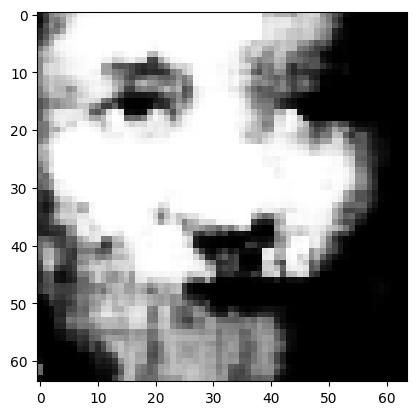

loss(generator):  0.5653762221336365
loss(generator):  0.5653654336929321
loss(generator):  0.5653542280197144
loss(generator):  0.5653427839279175
loss(generator):  0.5653325915336609
loss(generator):  0.5653213262557983
loss(generator):  0.5653109550476074
loss(generator):  0.5653006434440613
loss(generator):  0.5652896761894226
loss(generator):  0.5652797818183899
loss(generator):  0.5652692914009094
loss(generator):  0.5652588605880737
loss(generator):  0.5652487874031067
loss(generator):  0.5652390122413635
loss(generator):  0.5652289986610413
loss(generator):  0.5652189254760742
loss(generator):  0.5652099847793579
loss(generator):  0.5651997923851013
loss(generator):  0.565190851688385
loss(generator):  0.5651810169219971
loss(generator):  0.5651717185974121
loss(generator):  0.5651624202728271
loss(generator):  0.5651533603668213
loss(generator):  0.5651445388793945
loss(generator):  0.5651357769966125
loss(generator):  0.5651272535324097
loss(generator):  0.5651183724403381
lo

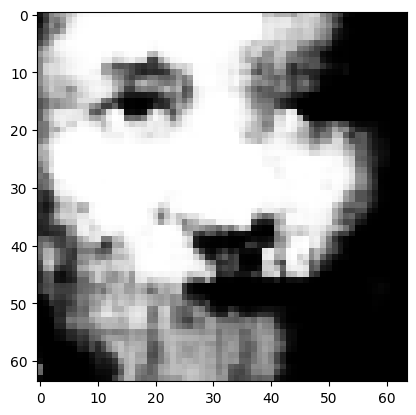

loss(generator):  0.5644059181213379
loss(generator):  0.5644041895866394
loss(generator):  0.5644026398658752
loss(generator):  0.5644015669822693
loss(generator):  0.5644001960754395
loss(generator):  0.5643985867500305
loss(generator):  0.5643970966339111
loss(generator):  0.5643956661224365
loss(generator):  0.5643946528434753
loss(generator):  0.5643928647041321
loss(generator):  0.5643916726112366
loss(generator):  0.5643901824951172
loss(generator):  0.5643893480300903
loss(generator):  0.5643873810768127
loss(generator):  0.5643859505653381
loss(generator):  0.5643846392631531
loss(generator):  0.5643836855888367
loss(generator):  0.5643826127052307
loss(generator):  0.564380943775177
loss(generator):  0.5643797516822815
loss(generator):  0.564378559589386
loss(generator):  0.5643773674964905
loss(generator):  0.5643764138221741
loss(generator):  0.5643752217292786
loss(generator):  0.5643740296363831
loss(generator):  0.5643724203109741
loss(generator):  0.5643711090087891
los

In [207]:
attack7 = torch.normal(0, 1, size=(1,64)).to(device)
attack7.requires_grad_(True)
optimize_z_eps(attack7, 1000, 1, 0.0001, 0.99, target=7)

In [208]:
torch.softmax(classifier(decoder(attack7)),-1)

tensor([[2.9161e-04, 5.9386e-04, 1.1125e-01, 2.1888e-03, 1.2236e-06, 7.0380e-05,
         2.7273e-04, 5.6877e-01, 9.4260e-05, 2.0098e-03, 2.5696e-02, 4.3250e-04,
         2.2650e-03, 1.6397e-02, 6.6780e-04, 1.0070e-04, 1.0760e-03, 1.2299e-05,
         4.1215e-04, 5.9909e-05, 1.1404e-02, 9.7800e-04, 2.3920e-04, 7.1188e-04,
         8.6836e-02, 3.3002e-02, 6.0922e-03, 1.1465e-02, 3.8426e-03, 5.9769e-05,
         1.9875e-04, 3.5699e-04, 1.6994e-04, 3.5722e-03, 2.5262e-03, 2.6780e-06,
         1.2681e-02, 5.6470e-02, 3.6118e-02, 6.0619e-04]],
       grad_fn=<SoftmaxBackward>)

loss(generator):  15.817351341247559


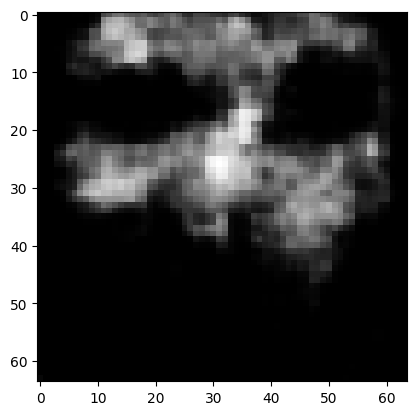

loss(generator):  13.618072509765625
loss(generator):  12.037782669067383
loss(generator):  9.737898826599121
loss(generator):  7.861069202423096
loss(generator):  6.4015302658081055
loss(generator):  5.22642707824707
loss(generator):  4.265571117401123
loss(generator):  3.358795642852783
loss(generator):  2.5977535247802734
loss(generator):  1.6888091564178467
loss(generator):  1.1886316537857056
loss(generator):  0.8545148968696594
loss(generator):  0.6949500441551208
loss(generator):  0.5994898080825806
loss(generator):  0.5276222825050354
loss(generator):  0.477373868227005
loss(generator):  0.4441690742969513
loss(generator):  0.4156394302845001
loss(generator):  0.39326784014701843
loss(generator):  0.37320518493652344
loss(generator):  0.3575346767902374
loss(generator):  0.34296485781669617
loss(generator):  0.32964783906936646
loss(generator):  0.31776779890060425
loss(generator):  0.3071909248828888
loss(generator):  0.29709529876708984
loss(generator):  0.2881019711494446
lo

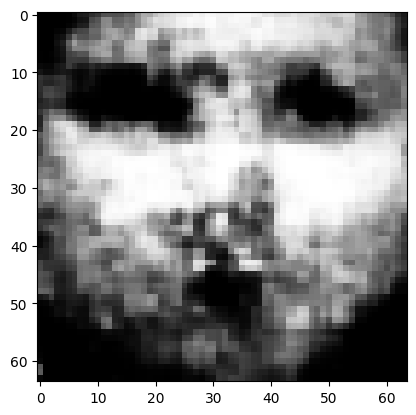

loss(generator):  0.12514261901378632
loss(generator):  0.12503007054328918
loss(generator):  0.1249188706278801
loss(generator):  0.12480923533439636
loss(generator):  0.12470106035470963
loss(generator):  0.1245938166975975
loss(generator):  0.1244877278804779
loss(generator):  0.12438373267650604
loss(generator):  0.12428151071071625
loss(generator):  0.12417885661125183
loss(generator):  0.12407641112804413
loss(generator):  0.12397520989179611
loss(generator):  0.12387505918741226
loss(generator):  0.12377573549747467
loss(generator):  0.12367851287126541
loss(generator):  0.12358170002698898
loss(generator):  0.12348603457212448
loss(generator):  0.12339162826538086
loss(generator):  0.1232980489730835
loss(generator):  0.12320563197135925
loss(generator):  0.123114675283432
loss(generator):  0.12302465736865997
loss(generator):  0.1229364275932312
loss(generator):  0.12285050004720688
loss(generator):  0.12276468425989151
loss(generator):  0.12268264591693878
loss(generator):  0

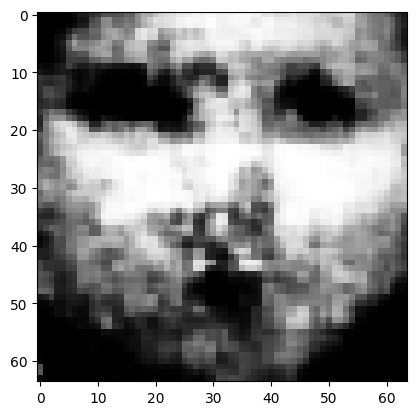

loss(generator):  0.11658492684364319
loss(generator):  0.11657378822565079
loss(generator):  0.11656307429075241
loss(generator):  0.11655214428901672
loss(generator):  0.11654195934534073
loss(generator):  0.11653102934360504
loss(generator):  0.11652084439992905
loss(generator):  0.11651076376438141
loss(generator):  0.11650057882070541
loss(generator):  0.11649081856012344
loss(generator):  0.11648063361644745
loss(generator):  0.11647097766399384
loss(generator):  0.11646121740341187
loss(generator):  0.11645166575908661
loss(generator):  0.11644233018159866
loss(generator):  0.11643277853727341
loss(generator):  0.11642376333475113
loss(generator):  0.11641485244035721
loss(generator):  0.11640572547912598
loss(generator):  0.11639712750911713
loss(generator):  0.1163882166147232
loss(generator):  0.11637973040342331
loss(generator):  0.11637123674154282
loss(generator):  0.11636263877153397
loss(generator):  0.11635436862707138
loss(generator):  0.11634619534015656
loss(generato

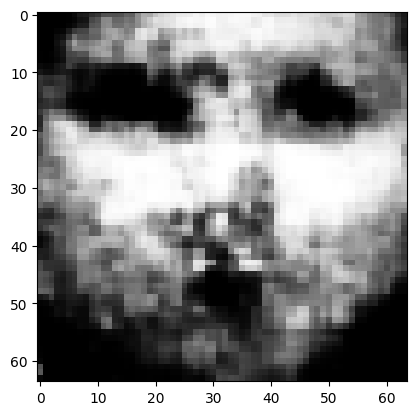

loss(generator):  0.11565885692834854
loss(generator):  0.11565736681222916
loss(generator):  0.11565577983856201
loss(generator):  0.1156546100974083
loss(generator):  0.11565280705690384
loss(generator):  0.11565184593200684
loss(generator):  0.11565014719963074
loss(generator):  0.1156487688422203
loss(generator):  0.11564759910106659
loss(generator):  0.11564632505178452
loss(generator):  0.11564484238624573
loss(generator):  0.11564356833696365
loss(generator):  0.11564228683710098
loss(generator):  0.11564122885465622
loss(generator):  0.11563973873853683
loss(generator):  0.11563857644796371
loss(generator):  0.11563708633184433
loss(generator):  0.11563602834939957
loss(generator):  0.11563475430011749
loss(generator):  0.11563348025083542
loss(generator):  0.11563262343406677
loss(generator):  0.11563114076852798
loss(generator):  0.11563007533550262
loss(generator):  0.1156289130449295
loss(generator):  0.11562784761190414
loss(generator):  0.11562667787075043
loss(generator)

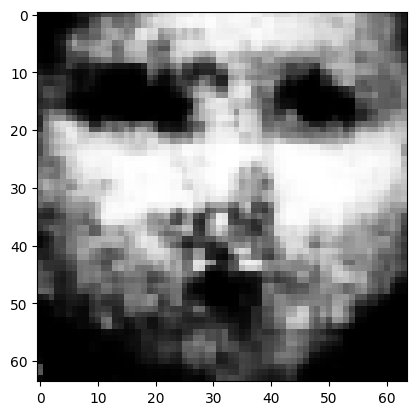

loss(generator):  0.11553588509559631
loss(generator):  0.115535669028759
loss(generator):  0.11553514003753662
loss(generator):  0.11553514003753662
loss(generator):  0.11553492397069931
loss(generator):  0.11553481966257095
loss(generator):  0.1155347153544426
loss(generator):  0.1155347153544426
loss(generator):  0.11553429067134857
loss(generator):  0.11553429067134857
loss(generator):  0.11553417891263962
loss(generator):  0.11553386598825455
loss(generator):  0.1155337542295456
loss(generator):  0.11553344130516052
loss(generator):  0.11553344130516052
loss(generator):  0.11553332954645157
loss(generator):  0.1155330166220665
loss(generator):  0.11553290486335754
loss(generator):  0.11553269624710083
loss(generator):  0.11553237587213516
loss(generator):  0.11553237587213516
loss(generator):  0.1155322715640068
loss(generator):  0.1155320554971695
loss(generator):  0.11553163081407547
loss(generator):  0.11553163081407547
loss(generator):  0.11553152650594711
loss(generator):  0.

In [201]:
attack8 = torch.normal(0, 1, size=(1,64)).to(device)
attack8.requires_grad_(True)
optimize_z_eps(attack8, 1000, 1, 0.0001, 0.99, target=8)

In [202]:
torch.softmax(classifier(decoder(attack8)),-1)

tensor([[9.8507e-06, 9.2554e-06, 6.7340e-04, 1.5780e-03, 2.7344e-05, 2.6441e-06,
         1.0810e-02, 1.3042e-06, 8.9090e-01, 4.6957e-03, 6.4170e-04, 9.8971e-04,
         8.1065e-04, 2.1175e-05, 2.5568e-04, 1.0456e-04, 7.6649e-03, 2.3546e-04,
         6.2967e-04, 2.1154e-04, 1.7620e-03, 1.4959e-03, 1.1792e-02, 1.0762e-03,
         4.9019e-03, 2.0883e-05, 3.8234e-04, 2.1748e-02, 2.1212e-02, 1.8262e-04,
         1.1539e-03, 1.1878e-05, 8.6158e-04, 2.0728e-05, 1.0815e-03, 2.9986e-05,
         2.8367e-04, 4.1796e-03, 9.0701e-04, 6.6202e-03]],
       grad_fn=<SoftmaxBackward>)

loss(generator):  13.627096176147461


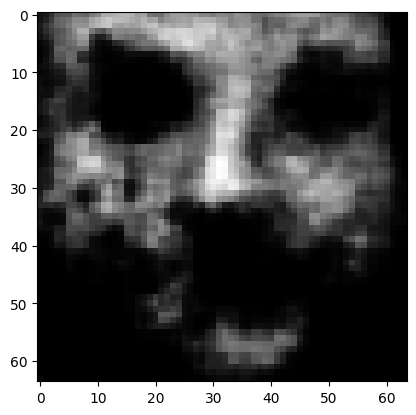

loss(generator):  11.964229583740234
loss(generator):  10.664222717285156
loss(generator):  9.871162414550781
loss(generator):  9.330879211425781
loss(generator):  8.920994758605957
loss(generator):  8.50947380065918
loss(generator):  8.025540351867676
loss(generator):  7.4316277503967285
loss(generator):  6.6843485832214355
loss(generator):  5.935716152191162
loss(generator):  5.078649044036865
loss(generator):  4.222101211547852
loss(generator):  3.7777109146118164
loss(generator):  3.3986711502075195
loss(generator):  3.154121160507202
loss(generator):  3.0234780311584473
loss(generator):  2.9020237922668457
loss(generator):  2.803680419921875
loss(generator):  2.6892449855804443
loss(generator):  2.55432391166687
loss(generator):  2.440336227416992
loss(generator):  2.3065059185028076
loss(generator):  2.192023515701294
loss(generator):  2.0715179443359375
loss(generator):  1.9522287845611572
loss(generator):  1.855302333831787
loss(generator):  1.7523674964904785
loss(generator): 

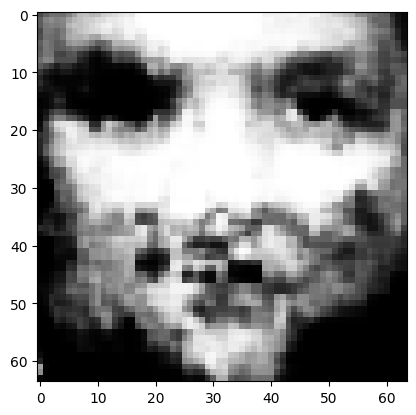

loss(generator):  0.28611740469932556
loss(generator):  0.2857983112335205
loss(generator):  0.2854856550693512
loss(generator):  0.28518837690353394
loss(generator):  0.2849091589450836
loss(generator):  0.2846388816833496
loss(generator):  0.2843715250492096
loss(generator):  0.2840973436832428
loss(generator):  0.2838360369205475
loss(generator):  0.28357768058776855
loss(generator):  0.2833179235458374
loss(generator):  0.2830662131309509
loss(generator):  0.28281188011169434
loss(generator):  0.2825610041618347
loss(generator):  0.28231799602508545
loss(generator):  0.28207480907440186
loss(generator):  0.2818297743797302
loss(generator):  0.2815878391265869
loss(generator):  0.2813510298728943
loss(generator):  0.28111591935157776
loss(generator):  0.2808774709701538
loss(generator):  0.28064513206481934
loss(generator):  0.28042280673980713
loss(generator):  0.28019005060195923
loss(generator):  0.2799702286720276
loss(generator):  0.27975064516067505
loss(generator):  0.2795473

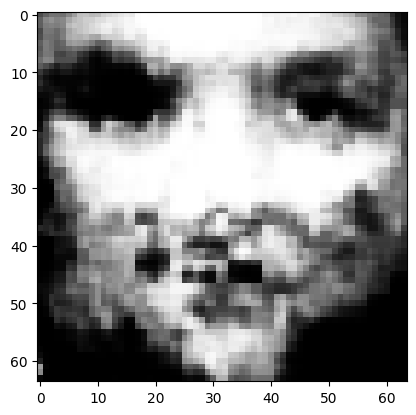

loss(generator):  0.2638491988182068
loss(generator):  0.2638208270072937
loss(generator):  0.2637940049171448
loss(generator):  0.2637658715248108
loss(generator):  0.26373639702796936
loss(generator):  0.2637098431587219
loss(generator):  0.2636827230453491
loss(generator):  0.2636549770832062
loss(generator):  0.2636282444000244
loss(generator):  0.2636023163795471
loss(generator):  0.2635766863822937
loss(generator):  0.26354965567588806
loss(generator):  0.2635239064693451
loss(generator):  0.263500839471817
loss(generator):  0.26347482204437256
loss(generator):  0.2634490728378296
loss(generator):  0.2634257376194
loss(generator):  0.26340043544769287
loss(generator):  0.2633768916130066
loss(generator):  0.26335445046424866
loss(generator):  0.2633289098739624
loss(generator):  0.26330527663230896
loss(generator):  0.26328280568122864
loss(generator):  0.2632608413696289
loss(generator):  0.26323699951171875
loss(generator):  0.263215035200119
loss(generator):  0.263193309307098

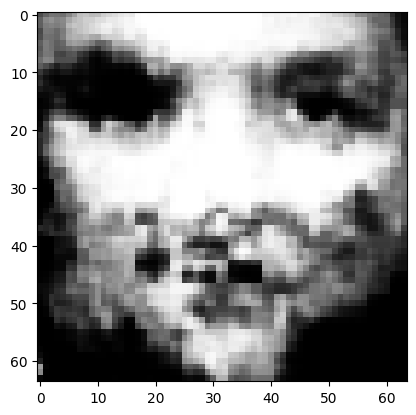

loss(generator):  0.2612227499485016
loss(generator):  0.2612180709838867
loss(generator):  0.2612133026123047
loss(generator):  0.2612099051475525
loss(generator):  0.2612054944038391
loss(generator):  0.26120108366012573
loss(generator):  0.26119694113731384
loss(generator):  0.26119300723075867
loss(generator):  0.2611885964870453
loss(generator):  0.2611851096153259
loss(generator):  0.2611807882785797
loss(generator):  0.2611764669418335
loss(generator):  0.2611730694770813
loss(generator):  0.26116958260536194
loss(generator):  0.2611652612686157
loss(generator):  0.2611618638038635
loss(generator):  0.26115792989730835
loss(generator):  0.2611546218395233
loss(generator):  0.2611505687236786
loss(generator):  0.26114699244499207
loss(generator):  0.26114368438720703
loss(generator):  0.261139839887619
loss(generator):  0.26113635301589966
loss(generator):  0.26113295555114746
loss(generator):  0.26112955808639526
loss(generator):  0.26112625002861023
loss(generator):  0.26112294

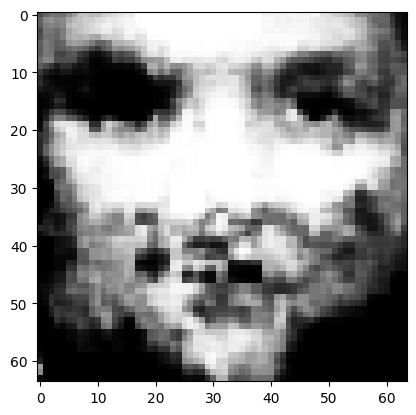

loss(generator):  0.26085180044174194
loss(generator):  0.2608511447906494
loss(generator):  0.26085078716278076
loss(generator):  0.2608499526977539
loss(generator):  0.26084959506988525
loss(generator):  0.2608489394187927
loss(generator):  0.2608487606048584
loss(generator):  0.26084792613983154
loss(generator):  0.2608474791049957
loss(generator):  0.26084691286087036
loss(generator):  0.26084664463996887
loss(generator):  0.26084598898887634
loss(generator):  0.26084545254707336
loss(generator):  0.2608451843261719
loss(generator):  0.26084470748901367
loss(generator):  0.2608438730239868
loss(generator):  0.26084333658218384
loss(generator):  0.26084280014038086
loss(generator):  0.2608424127101898
loss(generator):  0.260841965675354
loss(generator):  0.2608417868614197
loss(generator):  0.2608409523963928
loss(generator):  0.26084059476852417
loss(generator):  0.26084011793136597
loss(generator):  0.260839581489563
loss(generator):  0.26083919405937195
loss(generator):  0.260838

In [215]:
attack9 = torch.normal(0, 1, size=(1,64)).to(device)
attack9.requires_grad_(True)
optimize_z_eps(attack9, 1000, 1, 0.0001, 0.99, target=9)

In [216]:
torch.softmax(classifier(decoder(attack9)),-1)

tensor([[1.3455e-04, 1.8026e-06, 8.7365e-03, 1.3170e-05, 1.4768e-03, 1.7453e-05,
         2.6629e-04, 2.0521e-04, 4.9143e-02, 7.7043e-01, 4.4672e-04, 7.4505e-04,
         3.2567e-04, 5.4355e-06, 6.7594e-05, 1.6487e-04, 2.4696e-03, 1.5318e-06,
         1.3503e-04, 1.7576e-04, 1.1182e-03, 1.7172e-03, 9.2266e-03, 1.1417e-04,
         1.0976e-02, 7.7982e-05, 5.4888e-05, 7.6895e-03, 2.5004e-03, 3.9564e-03,
         1.1429e-03, 5.9326e-07, 4.2475e-04, 3.0760e-05, 2.2953e-02, 9.4289e-05,
         3.9209e-04, 1.2451e-03, 4.2813e-04, 1.0089e-01]],
       grad_fn=<SoftmaxBackward>)

In [217]:
# When regularization strength is weak, the classifier has a higher confidence to predict the generated result as 
# the attack target

# However, the quality of generation may not be worse. It appears that high regularization gives better result.

loss(generator):  15.49824333190918


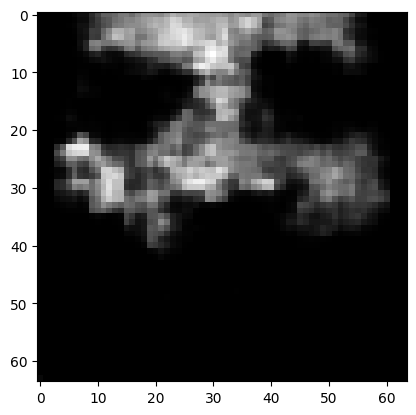

loss(generator):  14.755965232849121
loss(generator):  13.947051048278809
loss(generator):  13.168379783630371
loss(generator):  12.142285346984863
loss(generator):  11.413328170776367
loss(generator):  10.872514724731445
loss(generator):  10.312482833862305
loss(generator):  9.589640617370605
loss(generator):  8.49713134765625
loss(generator):  7.4344682693481445
loss(generator):  5.637800216674805
loss(generator):  3.8318562507629395
loss(generator):  2.5626580715179443
loss(generator):  1.8584532737731934
loss(generator):  1.465569257736206
loss(generator):  1.220637321472168
loss(generator):  1.0589381456375122
loss(generator):  0.9491173624992371
loss(generator):  0.8601809740066528
loss(generator):  0.779811680316925
loss(generator):  0.7133126258850098
loss(generator):  0.6635900735855103
loss(generator):  0.6216983199119568
loss(generator):  0.5801012516021729
loss(generator):  0.5430757999420166
loss(generator):  0.5119038224220276
loss(generator):  0.48655521869659424
loss(ge

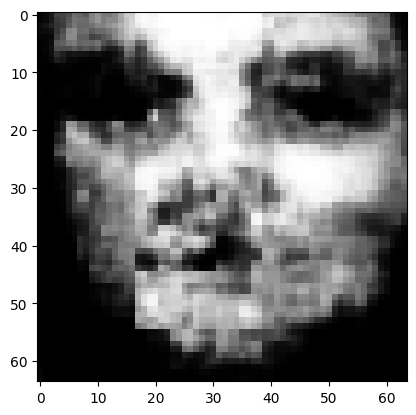

loss(generator):  0.2478831559419632
loss(generator):  0.24783411622047424
loss(generator):  0.24779541790485382
loss(generator):  0.2477923333644867
loss(generator):  0.24771437048912048
loss(generator):  0.24769528210163116
loss(generator):  0.24765360355377197
loss(generator):  0.24763350188732147
loss(generator):  0.24762800335884094
loss(generator):  0.24758380651474
loss(generator):  0.2475612759590149
loss(generator):  0.24755141139030457
loss(generator):  0.2475207895040512
loss(generator):  0.24751874804496765
loss(generator):  0.24747323989868164
loss(generator):  0.24745973944664001
loss(generator):  0.24743275344371796
loss(generator):  0.24740733206272125
loss(generator):  0.24739915132522583
loss(generator):  0.24736638367176056
loss(generator):  0.2473554015159607
loss(generator):  0.2473239302635193
loss(generator):  0.2473059594631195
loss(generator):  0.2472962886095047
loss(generator):  0.24726602435112
loss(generator):  0.24725942313671112
loss(generator):  0.247226

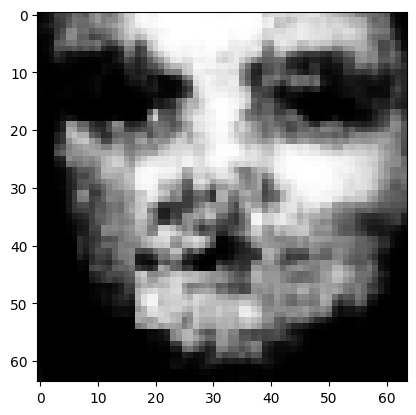

loss(generator):  0.2431079000234604
loss(generator):  0.24309630692005157
loss(generator):  0.2430863082408905
loss(generator):  0.24308069050312042
loss(generator):  0.2430674135684967
loss(generator):  0.2430604100227356
loss(generator):  0.24304881691932678
loss(generator):  0.24304404854774475
loss(generator):  0.2430345118045807
loss(generator):  0.2430279701948166
loss(generator):  0.2430165559053421
loss(generator):  0.24300935864448547
loss(generator):  0.24300029873847961
loss(generator):  0.24299196898937225
loss(generator):  0.2429836541414261
loss(generator):  0.24297411739826202
loss(generator):  0.24296841025352478
loss(generator):  0.24296055734157562
loss(generator):  0.24294981360435486
loss(generator):  0.2429443895816803
loss(generator):  0.24293465912342072
loss(generator):  0.24292989075183868
loss(generator):  0.24292054772377014
loss(generator):  0.24291455745697021
loss(generator):  0.24290530383586884
loss(generator):  0.24289613962173462
loss(generator):  0.2

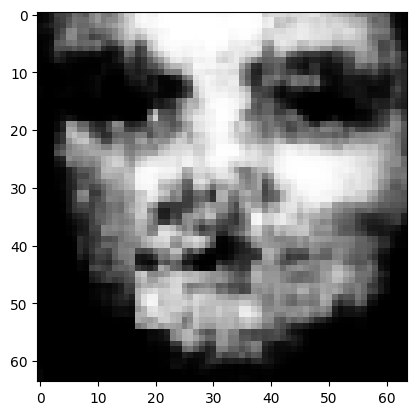

loss(generator):  0.24228978157043457
loss(generator):  0.24228893220424652
loss(generator):  0.24228724837303162
loss(generator):  0.24228613078594208
loss(generator):  0.2422846406698227
loss(generator):  0.24228359758853912
loss(generator):  0.24228248000144958
loss(generator):  0.24228154122829437
loss(generator):  0.24228033423423767
loss(generator):  0.24227865040302277
loss(generator):  0.24227789044380188
loss(generator):  0.2422761172056198
loss(generator):  0.24227508902549744
loss(generator):  0.24227406084537506
loss(generator):  0.24227266013622284
loss(generator):  0.24227172136306763
loss(generator):  0.24227078258991241
loss(generator):  0.24227049946784973
loss(generator):  0.24226807057857513
loss(generator):  0.2422674149274826
loss(generator):  0.2422662079334259
loss(generator):  0.2422652691602707
loss(generator):  0.24226433038711548
loss(generator):  0.24226292967796326
loss(generator):  0.24226245284080505
loss(generator):  0.2422611564397812
loss(generator):  

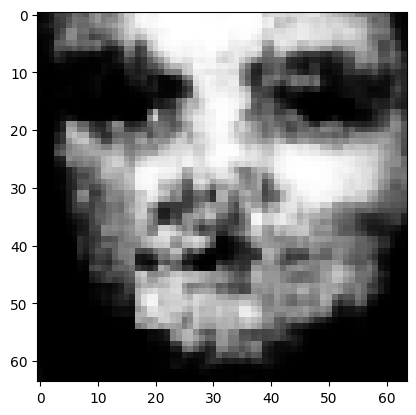

loss(generator):  0.2421777844429016
loss(generator):  0.2421775907278061
loss(generator):  0.24217750132083893
loss(generator):  0.2421773076057434
loss(generator):  0.24217712879180908
loss(generator):  0.2421768456697464
loss(generator):  0.24217675626277924
loss(generator):  0.2421768456697464
loss(generator):  0.24217627942562103
loss(generator):  0.24217647314071655
loss(generator):  0.24217601120471954
loss(generator):  0.2421761006116867
loss(generator):  0.24217572808265686
loss(generator):  0.2421759068965912
loss(generator):  0.24217572808265686
loss(generator):  0.24217553436756134
loss(generator):  0.24217553436756134
loss(generator):  0.24217507243156433
loss(generator):  0.24217507243156433
loss(generator):  0.24217498302459717
loss(generator):  0.24217469990253448
loss(generator):  0.24217422306537628
loss(generator):  0.24217450618743896
loss(generator):  0.2421744167804718
loss(generator):  0.2421739399433136
loss(generator):  0.2421739399433136
loss(generator):  0.24

In [237]:
attack9 = torch.normal(0, 1, size=(1,64)).to(device)
attack9.requires_grad_(True)
optimize_z_eps(attack9, 1000, 1, 0.006, 0.99, target=9)

In [238]:
torch.softmax(classifier(decoder(attack9)),-1)

tensor([[4.6566e-05, 1.6110e-06, 4.3099e-02, 4.4596e-06, 3.3246e-04, 9.3833e-07,
         4.0438e-05, 2.0221e-04, 1.0893e-02, 7.8493e-01, 7.3902e-04, 3.6155e-05,
         2.1008e-04, 2.1703e-06, 1.2029e-05, 2.0226e-04, 4.2977e-03, 3.5300e-08,
         4.8769e-05, 8.3892e-04, 1.0754e-03, 2.6687e-02, 7.2822e-04, 5.0763e-05,
         2.7572e-04, 1.0115e-06, 2.2803e-05, 3.4634e-03, 3.3028e-02, 1.9791e-02,
         6.2582e-04, 2.0693e-08, 2.5427e-03, 6.9367e-05, 2.1565e-02, 2.2376e-04,
         1.4849e-03, 9.5671e-04, 1.0255e-03, 4.0446e-02]],
       grad_fn=<SoftmaxBackward>)

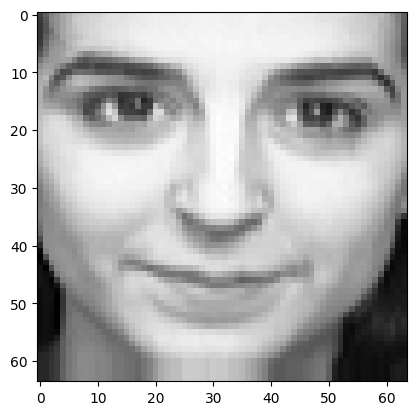

In [226]:
tensor_to_picture(test_data[94].detach().cpu().numpy()[0][0])